# **Цель проекта**


**Создание модели на основе данных, собранных из открытых источников, которая будет предсказывать стоимость автомобиля на вторичном рынке по его характеристикам с целью нахождения предложений ниже среднего по рынку**

# Подготовка

## Загрузка данных и подключение необходимых библиотек

In [ ]:
# pip install catboost

In [2]:
# pip install --upgrade pandas --user

In [3]:
# !pip install pandas-profiling==2.7.1 # необходимо выполнить при запуске ноутбука в colab

In [4]:
# pip install -U scikit-learn # если версия <0.24

In [5]:
import pandas as pd
import numpy as np
import re
import pandas_profiling
from pandas_profiling import ProfileReport
from unicodedata import normalize
from pandas.api.types import CategoricalDtype
# import lazypredict
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_percentage_error # версия sklearn должна быть >= 0.24
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor

np.set_printoptions(threshold=100, edgeitems=10)
pd.set_option('display.max_columns',None)
# pd.set_option('display.float_format','{:,.4f}'.format)

In [6]:
df = pd.read_csv('parsing_data_07_2021.csv') # данные, полученнные с auto.ru
test = pd.read_csv('test_kaggle.csv')
df.head(3)

,owners,length_of_ownership,engine,vehicleTransmission,bodyType,vehicle_passport,vehicle_drive,mileage,steering,color,brand,productionDate,model_name,vehicle_price
0,1 владелец,NaN,1.4 л / 150 л.с. / Бензин,роботизированная,седан,Оригинал,передний,13 000 км,Левый,белый,Audi,2019,A3 III (8V) Рестайлинг,1 550 000 ₽
1,3 или более,3 месяца,4.2 л / 450 л.с. / Бензин,роботизированная,универсал 5 дв.,Оригинал,полный,122 000 км,Левый,синий,Audi,2013,RS 4 III (B8),2 100 000 ₽
2,3 или более,3 года и 3 месяца,2.0 л / 225 л.с. / Бензин,роботизированная,лифтбек,Оригинал,полный,95 000 км,Левый,коричневый,Audi,2014,A5 Sportback I (8T) Рестайлинг,1 600 000 ₽


In [7]:
test.head(3)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [8]:
# Признаки, которые есть в test, но нет в df
[col for col in test.columns if col not in df.columns]

['car_url',
 'complectation_dict',
 'description',
 'engineDisplacement',
 'enginePower',
 'equipment_dict',
 'fuelType',
 'image',
 'modelDate',
 'model_info',
 'name',
 'numberOfDoors',
 'parsing_unixtime',
 'priceCurrency',
 'sell_id',
 'super_gen',
 'vehicleConfiguration',
 'vendor',
 'Владельцы',
 'Владение',
 'ПТС',
 'Привод',
 'Руль',
 'Состояние',
 'Таможня']

Удалим из test признаки, которые не имеют значения для обучения, дублируют даные в других признаках, отсутствуют в данных парсинга.

In [9]:
test.drop(['car_url', 'complectation_dict', 'description', 'equipment_dict', 'image',
           'modelDate', 'model_info', 'name', 'parsing_unixtime', 'priceCurrency',
           'sell_id', 'super_gen', 'vehicleConfiguration','vendor',
          'Состояние','Таможня'], axis=1, inplace=True)

Приведем наименования признаков test в соответствие наименованиям признаков df

In [10]:
columns_dict = {'Владельцы': 'owners',
                   'Владение': 'length_of_ownership',
                   'ПТС': 'vehicle_passport',
                   'Привод': 'vehicle_drive',
                   'Руль': 'steering'}
test.rename(columns_dict, axis=1, inplace=True)

In [11]:
test.sample(3)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,model_name,numberOfDoors,productionDate,vehicleTransmission,owners,length_of_ownership,vehicle_passport,vehicle_drive,steering
29414,седан,BMW,серебристый,2.0 LTR,184 N12,бензин,85000,3ER,4,2013,автоматическая,1 владелец,7 лет и 6 месяцев,Оригинал,задний,Левый
26206,минивэн,VOLKSWAGEN,серебристый,2.0 LTR,140 N12,дизель,210000,CARAVELLE,4,2011,механическая,3 или более,8 лет и 9 месяцев,Дубликат,передний,Левый
5282,внедорожник 5 дв.,HONDA,коричневый,2.4 LTR,194 N12,бензин,117554,CROSSTOUR,5,2013,автоматическая,1 владелец,NaN,Оригинал,передний,Левый


## Первоначальный анализ данных

### Сравнение признаков в датасетах

In [12]:
# Признаки, которые есть в df, но нет в test
[col for col in df.columns if col not in test.columns]

['engine', 'vehicle_price']

In [13]:
# Признаки, которые есть в test, но нет в df
[col for col in test.columns if col not in df.columns]

['engineDisplacement', 'enginePower', 'fuelType', 'numberOfDoors']

Посмотрим на них

In [14]:
df.engine.sample(3)

3463    3.0 л / 286 л.с. / Дизель
1478    1.8 л / 190 л.с. / Бензин
3111    2.0 л / 150 л.с. / Дизель
Name: engine, dtype: object

In [15]:
test[['engineDisplacement', 'enginePower', 'fuelType']].sample(3)

,engineDisplacement,enginePower,fuelType
22090,2.0 LTR,152 N12,бензин
21482,1.6 LTR,132 N12,бензин
17741,2.0 LTR,245 N12,бензин


In [16]:
test['numberOfDoors'].sample(3)

10439    4
27303    4
23497    4
Name: numberOfDoors, dtype: int64

- **'vehicle_price'** - стоимость автомобиля. Целевая переменная.
- **'engine'** и **'engineDisplacement', 'enginePower', 'fuelType'** содержат одни и те же сведения. **'engine'** следует разделить на три признака 
- **'numberOfDoors'** - количество дверей. Информация в df частично присутствует в признаке **bodyType**. Следует извлечь её.

In [17]:
df[df.engine.isna()]

,owners,length_of_ownership,engine,vehicleTransmission,bodyType,vehicle_passport,vehicle_drive,mileage,steering,color,brand,productionDate,model_name,vehicle_price
7403,3 или более,NaN,NaN,NaN,NaN,Оригинал,NaN,400 000 км,Левый,серебристый,Honda,1989,Civic,120 000 ₽


Учитывая, что основных параметров по Civic в df нет, удалим данный экземпляр

In [18]:
df.drop([7403],inplace=True)

### Приведение данных в признаках к одной форме, очистка данных, заполнение недостающих сведений

#### **engine**

Разделим данные из engine на три признака: объем двигателя, мощность двигателя, вид топлива

In [19]:
df[['engineDisplacement', 'enginePower', 'fuelType']
   ] = df.engine.str.split(pat=' / ', n=2, expand=True)
df.drop('engine', axis=1, inplace=True)
df.sample(3)

,owners,length_of_ownership,vehicleTransmission,bodyType,vehicle_passport,vehicle_drive,mileage,steering,color,brand,productionDate,model_name,vehicle_price,engineDisplacement,enginePower,fuelType
10316,1 владелец,NaN,автоматическая,внедорожник 5 дв.,Оригинал,полный,56 766 км,Левый,коричневый,Mercedes-Benz,2017,GLC I (X253) 220 d,2 619 000 ₽,2.1 л,170 л.с.,Дизель
3764,1 владелец,5 лет и 2 месяца,автоматическая,седан,Оригинал,задний,114 000 км,Левый,чёрный,BMW,2015,3 серии VI (F3x) Рестайлинг 318i,1 410 000 ₽,1.5 л,136 л.с.,Бензин
7102,3 или более,8 лет и 6 месяцев,вариатор,хэтчбек 5 дв.,Оригинал,передний,256 000 км,Правый,белый,Honda,2008,Fit II,380 000 ₽,1.3 л,100 л.с.,Бензин


#### **fuelType, engineDisplacement, enginePower**

Посмотрим на форму данных в обоих датасетах

In [20]:
pd.concat([pd.Series(df.fuelType.value_counts(), name='df'),
          pd.Series(test.fuelType.value_counts(),name='test')], axis=1)

,df,test
Бензин,16735.0,NaN
Дизель,4193.0,NaN
Гибрид,201.0,NaN
"Бензин, газобаллонное оборудование",166.0,NaN
Электро,28.0,NaN
"Дизель, газобаллонное оборудование",1.0,NaN
бензин,NaN,28601.0
дизель,NaN,5800.0
гибрид,NaN,223.0
электро,NaN,55.0


Наименование не совпадают, необходимо привести к одной форме. Посмотрим на электродвигатели

In [21]:
df[df.fuelType=='Электро'][['engineDisplacement','enginePower']].head()

,engineDisplacement,enginePower
120,408 л.с.,300 кВт
147,408 л.с.,300 кВт
527,408 л.с.,300 кВт
2099,408 л.с.,300 кВт
2872,530 л.с.,390 кВт


In [22]:
test[test.fuelType=='электро'][['engineDisplacement','enginePower']].head()

,engineDisplacement,enginePower
5241,LTR,408 N12
7992,LTR,170 N12
8252,LTR,170 N12
8350,LTR,170 N12
8684,LTR,170 N12


Электродвигатели не обладают объемом, исходя из этого заполним **'engineDisplacement','enginePower'** соответствующим образом, дополнительно убрав из признаков лишнюю информацию и приведя типы двигателя к единой форме

In [23]:
df.fuelType = df.fuelType.str.replace('Бензин, газобаллонное оборудование','газ')
df.fuelType = df.fuelType.str.replace('Дизель, газобаллонное оборудование','газ')
df.fuelType = df.fuelType.str.lower()

In [24]:
df['enginePower'] = df[['fuelType', 'engineDisplacement', 'enginePower']].apply(
    lambda x: x[1] if x[0] == 'электро' else x[2],axis=1)
df['enginePower'] = df['enginePower'].apply(lambda x: x.split()[0]).astype('float64')
df['engineDisplacement'] = df['engineDisplacement'].apply(lambda x: x.split()[0])
df['engineDisplacement'] = df[['fuelType', 'engineDisplacement']].apply(
    lambda x: 0 if x[0] == 'электро' else x[1],axis=1).astype('float64')

In [25]:
df[df.fuelType=='электро'][['engineDisplacement','enginePower']].head()

,engineDisplacement,enginePower
120,0.0,408.0
147,0.0,408.0
527,0.0,408.0
2099,0.0,408.0
2872,0.0,530.0


In [26]:
test['enginePower'] = test['enginePower'].apply(lambda x: x.split()[0])
test['engineDisplacement'] = test['engineDisplacement'].str.replace(' LTR', '')
test['engineDisplacement'] = test['engineDisplacement'].apply(
    lambda x: 0 if x == '' else x).astype('float64')

In [27]:
test[test.fuelType=='электро'][['engineDisplacement','enginePower']].head()

,engineDisplacement,enginePower
5241,0.0,408
7992,0.0,170
8252,0.0,170
8350,0.0,170
8684,0.0,170


Проверим, совпадают ли теперь данные по форме

In [28]:
pd.concat([pd.Series(df.fuelType.value_counts(), name='df'),
          pd.Series(test.fuelType.value_counts(),name='test')], axis=1)

,df,test
бензин,16735,28601
дизель,4193,5800
гибрид,201,223
газ,167,7
электро,28,55


#### **numberOfDoors**

Посмотрим соответствие типов кузовов количеству дверей

In [29]:
doors_body = pd.DataFrame(test.groupby('numberOfDoors').bodyType.value_counts()).index
doors_body[:10]

MultiIndex([(0,               'кабриолет'),
            (2,                    'купе'),
            (2,            'купе-хардтоп'),
            (2,                 'родстер'),
            (2,               'кабриолет'),
            (2,           'хэтчбек 3 дв.'),
            (2,             'седан 2 дв.'),
            (2,  'пикап одинарная кабина'),
            (2, 'пикап полуторная кабина'),
            (2,                   'тарга')],
           names=['numberOfDoors', 'bodyType'])

Поместим полученные кортежи в датафрейм, разделим их элементы на отдельные столбцы и сгруппируем данные по типам кузовов

In [30]:
df_doors_body = pd.DataFrame(doors_body)
df_doors_body['number_of_doors'] = df_doors_body[0].apply(lambda x: x[0])
df_doors_body['bode_type'] = df_doors_body[0].apply(lambda x: x[1])
df_doors_body.groupby('bode_type').number_of_doors.value_counts()

bode_type                number_of_doors
внедорожник 3 дв.        3                  1
внедорожник 5 дв.        5                  1
внедорожник открытый     2                  1
                         3                  1
кабриолет                0                  1
                         2                  1
компактвэн               3                  1
                         4                  1
                         5                  1
купе                     2                  1
купе-хардтоп             2                  1
лимузин                  4                  1
лифтбек                  5                  1
микровэн                 5                  1
минивэн                  3                  1
                         4                  1
                         5                  1
пикап двойная кабина     4                  1
пикап одинарная кабина   2                  1
пикап полуторная кабина  2                  1
                         4             

Проверим типы кузовов с множеством значений

In [31]:
test[test.bodyType=='внедорожник открытый'][['numberOfDoors','model_name','brand']]

,numberOfDoors,model_name,brand
15779,3,G_KLASSE,MERCEDES
17738,2,G_KLASSE,MERCEDES
33492,3,RAV_4,TOYOTA


Видимо это так называемые внедорожники-кабриолеты. Оставим количество дверей - 3

In [32]:
test[(test.bodyType == 'кабриолет') & (test.numberOfDoors == 0)][[
    'numberOfDoors', 'model_name', 'brand', 'productionDate']]

,numberOfDoors,model_name,brand,productionDate
16944,0,SIMPLEX,MERCEDES,1904


Автомобиль эксклюзивный, действительно без дверей. Учитывая его редкость, для кабриолетов оставим количество дверей - 2 

**компактвэн, минивэн, пикап полуторная кабина, фургон** - для них возможны варианты с разным количеством дверей. Пока не будем их учитывать при составлении словаря

Для **хэтчбек 3 дв** произведем замену значений на 3 

In [33]:
test.numberOfDoors = test[['bodyType', 'numberOfDoors']].apply(
    lambda x: 3 if x[0] == 'хэтчбек 3 дв.' and x[1] == 2 else x[1], axis=1)

Получим словарь соответствия кузова количеству дверей

In [34]:
dict_x = {doors_body[i][1]:doors_body[i][0] for i in range(len(doors_body))}
dict_x

{'кабриолет': 2,
 'купе': 2,
 'купе-хардтоп': 2,
 'родстер': 2,
 'хэтчбек 3 дв.': 3,
 'седан 2 дв.': 2,
 'пикап одинарная кабина': 2,
 'пикап полуторная кабина': 4,
 'тарга': 2,
 'внедорожник открытый': 3,
 'внедорожник 3 дв.': 3,
 'фургон': 4,
 'минивэн': 5,
 'компактвэн': 5,
 'фастбек': 3,
 'седан': 4,
 'пикап двойная кабина': 4,
 'седан-хардтоп': 4,
 'лимузин': 4,
 'внедорожник 5 дв.': 5,
 'лифтбек': 5,
 'хэтчбек 5 дв.': 5,
 'универсал 5 дв.': 5,
 'микровэн': 5}

Удалим из него **компактвэн, минивэн, пикап полуторная кабина, фургон**

In [35]:
body_mis_doors = ['компактвэн', 'минивэн', 'пикап полуторная кабина', 'фургон']
for key in body_mis_doors:
    del dict_x[key]

Создадим в df новый столбец numberOfDoors и заполним его в соответствии со словарем.

In [36]:
df['numberOfDoors'] = df.bodyType.apply(lambda x: dict_x[x] if x in dict_x.keys() else np.nan)

In [37]:
df[df.numberOfDoors.isna()].bodyType.unique()

array(['компактвэн', 'минивэн', 'фургон', 'пикап полуторная кабина'],
      dtype=object)

Для каждого из 4 оставшихся типов кузова сопоставим бренд и марку ТС с количеством дверей составив соответствующие группы (по кол-ву дверей)

In [38]:
# компактвэн

compact_3 = test[(test.bodyType == 'компактвэн') & (test.numberOfDoors == 3)][[
    'brand', 'model_name']].value_counts().index
compact_3 = pd.DataFrame(compact_3)[0].to_list()
compact_4 = test[(test.bodyType == 'компактвэн') & (test.numberOfDoors == 4)][[
    'brand', 'model_name']].value_counts().index
compact_4 = pd.DataFrame(compact_4)[0].to_list()
compact_5 = test[(test.bodyType == 'компактвэн') & (test.numberOfDoors == 5)][[
    'brand', 'model_name']].value_counts().index
compact_5 = pd.DataFrame(compact_5)[0].to_list()
compact_5[:5]

[('VOLKSWAGEN', 'TOURAN'),
 ('VOLKSWAGEN', 'CADDY'),
 ('TOYOTA', 'VERSO'),
 ('MITSUBISHI', 'SPACE_STAR'),
 ('MITSUBISHI', 'SPACE_WAGON')]

Проведем проверку, нет ли совпадений наименований в группах

In [39]:
# Определим самую большую группу и остальные будем сравнивать с ней
print(len(compact_3),len(compact_4),len(compact_5))

3 6 43


In [40]:
for i in range(len(compact_5)):
    if compact_5[i] in compact_3:
        print('compact_3: ',compact_5[i])
    if compact_5[i] in compact_4:
        print('compact_4: ',compact_5[i])

compact_3:  ('VOLKSWAGEN', 'CADDY')
compact_4:  ('VOLKSWAGEN', 'CADDY')
compact_4:  ('MITSUBISHI', 'RVR')
compact_4:  ('TOYOTA', 'TOWN_ACE')


Присвоим совпадающим наименованиям значения из бОльших по численности групп (начнем добавлять в самую маленькую группу элементы из следующей по численности группы, если ключ совпадает, ему присваивается значение из добавляемой группы, далее операция повторяется с добавлениме элементов из самой большой группы).

In [41]:
compact_temp_3 = {compact_3[i]:3 for i in range(len(compact_3))}
compact_temp_4 = {compact_4[i]:4 for i in range(len(compact_4))}
compact_temp_5 = {compact_5[i]:5 for i in range(len(compact_5))}
compact_all = compact_temp_3.copy()
for key in compact_temp_4.keys():
    compact_all[key] = 4
for key in compact_temp_5.keys():
    compact_all[key] = 5
compact_all

{('VOLKSWAGEN', 'CADDY'): 5,
 ('TOYOTA', 'PORTE'): 3,
 ('TOYOTA', 'SPADE'): 3,
 ('TOYOTA', 'TOWN_ACE'): 5,
 ('TOYOTA', 'LITE_ACE'): 4,
 ('NISSAN', 'SERENA'): 4,
 ('MITSUBISHI', 'SPACE_RUNNER'): 4,
 ('MITSUBISHI', 'RVR'): 5,
 ('VOLKSWAGEN', 'TOURAN'): 5,
 ('TOYOTA', 'VERSO'): 5,
 ('MITSUBISHI', 'SPACE_STAR'): 5,
 ('MITSUBISHI', 'SPACE_WAGON'): 5,
 ('SKODA', 'ROOMSTER'): 5,
 ('NISSAN', 'CUBE'): 5,
 ('HONDA', 'STREAM'): 5,
 ('MITSUBISHI', 'CHARIOT'): 5,
 ('HONDA', 'FREED'): 5,
 ('TOYOTA', 'COROLLA_SPACIO'): 5,
 ('NISSAN', 'LIBERTY'): 5,
 ('NISSAN', 'ALMERA_TINO'): 5,
 ('TOYOTA', 'BB'): 5,
 ('MITSUBISHI', 'DION'): 5,
 ('HONDA', 'SHUTTLE'): 5,
 ('HONDA', 'ODYSSEY'): 5,
 ('TOYOTA', 'IPSUM'): 5,
 ('TOYOTA', 'FUNCARGO'): 5,
 ('TOYOTA', 'COROLLA_VERSO'): 5,
 ('TOYOTA', 'ISIS'): 5,
 ('BMW', '2ACTIVETOURER'): 5,
 ('HONDA', 'MOBILIO'): 5,
 ('BMW', '2GRANDTOURER'): 5,
 ('TOYOTA', 'AVENSIS_VERSO'): 5,
 ('HONDA', 'FR_V'): 5,
 ('TOYOTA', 'RAUM'): 5,
 ('TOYOTA', 'PICNIC'): 5,
 ('NISSAN', 'TINO'): 5,
 (

Повторим для остальных типов кузовов

In [42]:
# минивэн

mini_3 = test[(test.bodyType == 'минивэн') & (test.numberOfDoors == 3)][[
    'brand', 'model_name']].value_counts().index
mini_3 = pd.DataFrame(mini_3)[0].to_list()
mini_4 = test[(test.bodyType == 'минивэн') & (test.numberOfDoors == 4)][[
    'brand', 'model_name']].value_counts().index
mini_4 = pd.DataFrame(mini_4)[0].to_list()
mini_5 = test[(test.bodyType == 'минивэн') & (test.numberOfDoors == 5)][[
    'brand', 'model_name']].value_counts().index
mini_5 = pd.DataFrame(mini_5)[0].to_list()

In [43]:
print(len(mini_3),len(mini_4),len(mini_5))

3 19 36


In [44]:
mini_temp_3 = {mini_3[i]:3 for i in range(len(mini_3))}
mini_temp_4 = {mini_4[i]:4 for i in range(len(mini_4))}
mini_temp_5 = {mini_5[i]:5 for i in range(len(mini_5))}
mini_all = mini_temp_3.copy()
for key in mini_temp_4.keys():
    mini_all[key] = 4
for key in mini_temp_5.keys():
    mini_all[key] = 5

In [45]:
# пикап полуторная кабина

pickup_2 = test[(test.bodyType == 'пикап полуторная кабина') & (test.numberOfDoors == 2)][[
    'brand', 'model_name']].value_counts().index
pickup_2 = pd.DataFrame(pickup_2)[0].to_list()
pickup_4 = test[(test.bodyType == 'пикап полуторная кабина') & (test.numberOfDoors == 4)][[
    'brand', 'model_name']].value_counts().index
pickup_4 = pd.DataFrame(pickup_4)[0].to_list()

In [46]:
print(len(pickup_2),len(pickup_4))

3 1


In [47]:
pickup_temp_2 = {pickup_2[i]:3 for i in range(len(pickup_2))}
pickup_temp_4 = {pickup_4[i]:4 for i in range(len(pickup_4))}
pickup_all = pickup_temp_4.copy()
for key in pickup_temp_2.keys():
    pickup_temp_4[key] = 2

In [48]:
# фургон

van_3 = test[(test.bodyType == 'фургон') & (test.numberOfDoors == 3)][[
    'brand', 'model_name']].value_counts().index
van_3 = pd.DataFrame(van_3)[0].to_list()
van_4 = test[(test.bodyType == 'фургон') & (test.numberOfDoors == 4)][[
    'brand', 'model_name']].value_counts().index
van_4 = pd.DataFrame(van_4)[0].to_list()

In [49]:
print(len(van_3),len(van_4))

1 1


In [50]:
print(van_3,van_4)

[('VOLKSWAGEN', 'TRANSPORTER')] [('VOLKSWAGEN', 'TRANSPORTER')]


In [51]:
van_all = {van_4[0]:4}

In [52]:
body_door_dict = {'компактвэн': compact_all,
                  'минивэн':mini_all,
                  'пикап полуторная кабина':pickup_all,
                  'фургон':van_all}

#### **brand и model_name**

Теперь посмотрим на значения **brand** и **model_name** в обоих датасетах

In [53]:
pd.merge(pd.DataFrame(sorted(df.brand.unique()),columns=['df']),
           pd.DataFrame(sorted(test.brand.unique()),columns=['test']),
         how='outer', left_on='df', right_on='test').T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
df,Audi,BMW,Honda,Infiniti,Lexus,Mercedes-Benz,Mitsubishi,Nissan,Skoda,Toyota,Volkswagen,Volvo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test,NaN,BMW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUDI,HONDA,INFINITI,LEXUS,MERCEDES,MITSUBISHI,NISSAN,SKODA,TOYOTA,VOLKSWAGEN,VOLVO


Приведем значения в df в соответствие с test

In [54]:
df.brand = df.brand.str.upper().replace('MERCEDES-BENZ','MERCEDES')
pd.merge(pd.DataFrame(sorted(df.brand.unique()),columns=['df']),
           pd.DataFrame(sorted(test.brand.unique()),columns=['test']),
         how='outer', left_on='df', right_on='test').T

,0,1,2,3,4,5,6,7,8,9,10,11
df,AUDI,BMW,HONDA,INFINITI,LEXUS,MERCEDES,MITSUBISHI,NISSAN,SKODA,TOYOTA,VOLKSWAGEN,VOLVO
test,AUDI,BMW,HONDA,INFINITI,LEXUS,MERCEDES,MITSUBISHI,NISSAN,SKODA,TOYOTA,VOLKSWAGEN,VOLVO


Наименования моделей в датасетах

In [55]:
df.model_name.unique()

array(['A3 III (8V) Рестайлинг', 'RS 4 III (B8)',
       'A5 Sportback I (8T) Рестайлинг',
       'RS 7 Sportback I (4G) Рестайлинг', 'S6 IV (C7) Рестайлинг',
       'A7 I (4G) Рестайлинг', 'A6 IV (C7) Рестайлинг', 'Q3 I (8U)',
       'A4 IV (B8)', 'Q7 I (4L) Рестайлинг', ..., 'V70 II',
       'S60 I Рестайлинг R', 'C70 I', '240 Series', 'C70 II', '740',
       '460', 'S40 I', 'V70 I', '960 I'], dtype=object)

In [56]:
test.model_name.unique()

array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', 'YETI', 'KODIAQ', 'RAPID',
       'FABIA', 'ROOMSTER', 'FELICIA', 'KAROQ', ..., 'LIBERO', 'DION',
       'EMERAUDE', 'ASPIRE', 'MINICA', 'ATLAS', 'WILL_CYPHA', 'PASEO',
       'WILL', 'PLATZ'], dtype=object)

Видно, что наименования в test более обобщенные, необходимо привести собранные данные к такой же форме

##### **AUDI**

In [57]:
audi_models_df = sorted((df.groupby('brand').model_name.unique())['AUDI'])
audi_models_test = sorted((test.groupby('brand').model_name.unique())['AUDI'])
display(np.array(audi_models_df))
np.array(audi_models_test)

array(['100 III (C3)', '100 III (C3) Рестайлинг', '100 IV (C4)',
       '100 IV (C4) S4', '200 II (C3)', '200 II (C3) Рестайлинг',
       '80 IV (B3)', '80 V (B4)', '90 I (B2)', '90 II (B3)', ...,
       'SQ8 I (4M)', 'TT I (8N)', 'TT I (8N) Рестайлинг', 'TT II (8J)',
       'TT II (8J) Рестайлинг', 'TT III (8S)', 'TT Roadster I (8N)',
       'TTS III (8S)', 'e-tron GT', 'e-tron I 55'], dtype='<U39')

array(['100', '200', '80', '90', '920', 'A1', 'A2', 'A3', 'A4',
       'A4_ALLROAD', 'A5', 'A6', 'A7', 'A8', 'ALLROAD', 'COUPE', 'E_TRON',
       'Q3', 'Q5', 'Q7', 'Q8', 'R8', 'RS3', 'RS4', 'RS5', 'RS6', 'RS7',
       'RSQ3', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'SQ5', 'TT', 'TTS',
       'TT_RS', 'V8'], dtype='<U10')

В test есть A4_ALLROAD и ALLROAD, в df A4 allroad и A6 allroad. Посмотрим на них

In [58]:
test[test.model_name.str.contains('ALLROAD')].groupby('engineDisplacement').model_name.value_counts()

engineDisplacement  model_name
2.0                 A4_ALLROAD    30
2.5                 ALLROAD        7
2.7                 ALLROAD       32
3.0                 ALLROAD       26
                    A4_ALLROAD     1
3.1                 ALLROAD       19
4.2                 ALLROAD        1
Name: model_name, dtype: int64

Согласно данным из [википедии](https://ru.wikipedia.org/wiki/Audi_Allroad_Quattro) А4 выпускались только с двигателями объемом 2.0 и 3.0 литра. Соответственно заменим ALLROAD на A6 allroad

In [59]:
test.model_name = test.model_name.apply(lambda x: 'A6 ALLROAD' if x == 'ALLROAD' else x)
test.model_name = test.model_name.str.replace('_',' ')

Напишем функцию обработки значений в df до формата данных в test

In [60]:
def models_formatting(string):
    mod_list = []
    exclude_list = ['I', 'II', 'III', 'IV', 'V', 'VI',
                    'VII', 'VIII', 'IX', 'X', 'XI', 'XII', 'XIII']
    re_list = string.split()
    mod_list.append(re_list[0].upper())
    for i in range(1, len(re_list)):
        if i == 1 and re_list[i].isdigit():
            mod_list[0] = mod_list[0]+re_list[i]
            return ' '.join(mod_list).upper()
        elif i == 1 and (re_list[i].isalpha() and len(re_list[i]) == 1 and re_list[i] not in exclude_list):
            mod_list[0] = mod_list[0]+' '+re_list[i]
            return ' '.join(mod_list).upper()
        elif i == 2 or (re_list[i] not in exclude_list and re_list[i].find('/') == -1 and re_list[i].find('(') == -1):
            mod_list.append(re_list[i])
            return ' '.join(mod_list).upper()
        else:
            return ' '.join(mod_list).upper()
    return string.upper()

In [61]:
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: models_formatting(x[1]) if x[0] == 'AUDI' else x[1], axis=1)

Результаты:

In [62]:
def models_comparison(f_name, df, test):
    temp_df = pd.DataFrame(sorted((df.groupby('brand').model_name.unique())[
                            f_name]), columns=[f_name+'_df'])
    temp_test = pd.DataFrame(sorted((test.groupby('brand').model_name.unique())[
        f_name]), columns=[f_name+'_test'])
    temp_both = pd.merge(temp_df, temp_test, how='outer',
                     left_on=temp_df.columns[0], right_on=temp_test.columns[0]).T
    return temp_both


models_comparison('AUDI', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
AUDI_df,100,200,80,90,920,A1,A1 SPORTBACK,A3,A3 SPORTBACK,A4,A4 ALLROAD,A5,A5 SPORTBACK,A6,A6 ALLROAD,A7,A8,A8 LONG,CABRIOLET,COUPE,E-TRON,E-TRON GT,Q3,Q3 SPORTBACK,Q5,Q7,Q8,R8,R8 GT,RS E-TRON,RS Q3,RS Q8,RS3,RS4,RS5,RS6,RS7,S3,S4,S5,S5 SPORTBACK,S6,S7 SPORTBACK,S8,SQ5,SQ7,SQ8,TT,TT ROADSTER,TTS,NaN,NaN,NaN,NaN,NaN,NaN
AUDI_test,100,200,80,90,920,A1,NaN,A3,NaN,A4,A4 ALLROAD,A5,NaN,A6,A6 ALLROAD,A7,A8,NaN,NaN,COUPE,NaN,NaN,Q3,NaN,Q5,Q7,Q8,R8,NaN,NaN,NaN,NaN,RS3,RS4,RS5,RS6,RS7,S3,S4,S5,NaN,S6,NaN,S8,SQ5,NaN,NaN,TT,NaN,TTS,A2,E TRON,RSQ3,S7,TT RS,V8


Дополнительно обработаем получившиеся наименования

In [63]:
test.model_name = test[['brand', 'model_name']].apply(
    lambda x: 'E-TRON' if x[0] == 'AUDI' and x[1]=='E TRON' else x[1], axis=1)
test.model_name = test[['brand', 'model_name']].apply(
    lambda x: 'RS Q3' if x[0] == 'AUDI' and x[1]=='RSQ3' else x[1], axis=1)
test.model_name = test[['brand', 'model_name']].apply(
    lambda x: 'S7 SPORTBACK' if x[0] == 'AUDI' and x[1]=='S7' else x[1], axis=1)

In [64]:
models_comparison('AUDI', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
AUDI_df,100,200,80,90,920,A1,A1 SPORTBACK,A3,A3 SPORTBACK,A4,A4 ALLROAD,A5,A5 SPORTBACK,A6,A6 ALLROAD,A7,A8,A8 LONG,CABRIOLET,COUPE,E-TRON,E-TRON GT,Q3,Q3 SPORTBACK,Q5,Q7,Q8,R8,R8 GT,RS E-TRON,RS Q3,RS Q8,RS3,RS4,RS5,RS6,RS7,S3,S4,S5,S5 SPORTBACK,S6,S7 SPORTBACK,S8,SQ5,SQ7,SQ8,TT,TT ROADSTER,TTS,NaN,NaN,NaN
AUDI_test,100,200,80,90,920,A1,NaN,A3,NaN,A4,A4 ALLROAD,A5,NaN,A6,A6 ALLROAD,A7,A8,NaN,NaN,COUPE,E-TRON,NaN,Q3,NaN,Q5,Q7,Q8,R8,NaN,NaN,RS Q3,NaN,RS3,RS4,RS5,RS6,RS7,S3,S4,S5,NaN,S6,S7 SPORTBACK,S8,SQ5,NaN,NaN,TT,NaN,TTS,A2,TT RS,V8


Сохраним модели, присутствующие в test, но отсутствующие в df, в отдельный список mismatch_model_withtest

In [65]:
mismatch_model_withtest = []
mismatch_audi = models_comparison('AUDI', df, test).T
mismatch_audi = mismatch_audi[mismatch_audi.AUDI_df.isna()].AUDI_test.to_list()
mismatch_model_withtest.extend(mismatch_audi)

Далее проведем такие же операции с моделями остальных производителей

##### **BMW**

In [66]:
bmw_models_df = sorted((df.groupby('brand').model_name.unique())['BMW'])
bmw_models_test = sorted((test.groupby('brand').model_name.unique())['BMW'])
display(np.array(bmw_models_df))
np.array(bmw_models_test)

array(['1 серии I (E81/E82/E87/E88) 116i',
       '1 серии I (E81/E82/E87/E88) 118i',
       '1 серии I (E81/E82/E87/E88) 120i',
       '1 серии I (E81/E82/E87/E88) 130i',
       '1 серии I (E81/E82/E87/E88) Рестайлинг 116d',
       '1 серии I (E81/E82/E87/E88) Рестайлинг 116i',
       '1 серии I (E81/E82/E87/E88) Рестайлинг 118d',
       '1 серии I (E81/E82/E87/E88) Рестайлинг 118i',
       '1 серии I (E81/E82/E87/E88) Рестайлинг 120d',
       '1 серии I (E81/E82/E87/E88) Рестайлинг 125i', ...,
       'Z4 II (E89) 23i', 'Z4 II (E89) 30i', 'Z4 II (E89) 35is',
       'Z4 II (E89) Рестайлинг 20i', 'i3 I (I01)', 'i3 I (I01) 94Ah',
       'i3 I (I01) Рестайлинг', 'i3 I (I01) Рестайлинг S', 'i8 I',
       'i8 I Рестайлинг'], dtype='<U60')

array(['02', '1ER', '2ACTIVETOURER', '2ER', '2GRANDTOURER', '321', '326',
       '340', '3ER', '4', '5ER', '6ER', '7ER', '8ER', 'E3', 'I3', 'I8',
       'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'X1', 'X2', 'X3', 'X3 M', 'X4',
       'X4 M', 'X5', 'X5 M', 'X6', 'X6 M', 'X7', 'Z1', 'Z3', 'Z3M', 'Z4'],
      dtype='<U13')

Заменим серии на их аббревиатуры

In [67]:
bmw_model_dict = {}
for i in range(1, 9):
    bmw_model_dict[str(i)+' серии'] = str(i)+'ER'
bmw_model_dict

{'1 серии': '1ER',
 '2 серии': '2ER',
 '3 серии': '3ER',
 '4 серии': '4ER',
 '5 серии': '5ER',
 '6 серии': '6ER',
 '7 серии': '7ER',
 '8 серии': '8ER'}

In [68]:
def change_bmw_name(string):
    if string[:7] in bmw_model_dict.keys():
        return bmw_model_dict[string[:7]]
    return string


df.model_name = df[['brand', 'model_name']].apply(
    lambda x: change_bmw_name(x[1]) if x[0] == 'BMW' else x[1], axis=1)
bmw_models_df = sorted((df.groupby('brand').model_name.unique())['BMW'])

In [69]:
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: models_formatting(x[1]) if x[0] == 'BMW' else x[1], axis=1)

In [70]:
models_comparison('BMW', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
BMW_df,1ER,2ER,340,3ER,4ER,5ER,6ER,7ER,8ER,I3,I8,M2 F87,M3,M4,M4 G82,M5,M6,M8 GRAN,X1,X2,X3,X4,X4 M,X5,X5 M,X6,X6 M,X7,Z3,Z3 M,Z4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BMW_test,1ER,2ER,340,3ER,NaN,5ER,6ER,7ER,8ER,I3,I8,NaN,M3,M4,NaN,M5,M6,NaN,X1,X2,X3,X4,X4 M,X5,X5 M,X6,X6 M,X7,Z3,NaN,Z4,02,2ACTIVETOURER,2GRANDTOURER,321,326,4,E3,M1,M2,X3 M,Z1,Z3M


In [71]:
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: 'M2' if x[0] == 'BMW' and x[1]=='M2 F87' else x[1], axis=1)
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: 'M4' if x[0] == 'BMW' and x[1]=='M4 G82' else x[1], axis=1)
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: 'M8' if x[0] == 'BMW' and x[1]=='M8 GRAN' else x[1], axis=1)
test.model_name = test[['brand', 'model_name']].apply(
    lambda x: '2ER' if x[0] == 'BMW' and x[1] in (['02','2ACTIVETOURER','2GRANDTOURER']) else x[1], axis=1)
test.model_name = test[['brand', 'model_name']].apply(
    lambda x: '4ER' if x[0] == 'BMW' and x[1] == '4' else x[1], axis=1)
test.model_name = test[['brand', 'model_name']].apply(
    lambda x: 'Z3 M' if x[0] == 'BMW' and x[1] == 'Z3M' else x[1], axis=1)

In [72]:
models_comparison('BMW', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
BMW_df,1ER,2ER,340,3ER,4ER,5ER,6ER,7ER,8ER,I3,I8,M2,M3,M4,M5,M6,M8,X1,X2,X3,X4,X4 M,X5,X5 M,X6,X6 M,X7,Z3,Z3 M,Z4,NaN,NaN,NaN,NaN,NaN,NaN
BMW_test,1ER,2ER,340,3ER,4ER,5ER,6ER,7ER,8ER,I3,I8,M2,M3,M4,M5,M6,NaN,X1,X2,X3,X4,X4 M,X5,X5 M,X6,X6 M,X7,Z3,Z3 M,Z4,321,326,E3,M1,X3 M,Z1


In [73]:
mismatch_bmw = models_comparison('BMW', df, test).T
mismatch_bmw = mismatch_bmw[mismatch_bmw.BMW_df.isna()].BMW_test.to_list()
mismatch_model_withtest.extend(mismatch_bmw)

##### **HONDA**

In [74]:
honda_models_df = sorted((df.groupby('brand').model_name.unique())['HONDA'])
honda_models_test = sorted((test.groupby('brand').model_name.unique())['HONDA'])
display(np.array(honda_models_df))
np.array(honda_models_test)

array(['Accord IV', 'Accord IX', 'Accord Type-S VII Type S',
       'Accord Type-S VII Рестайлинг Type S', 'Accord Type-S VIII Type S',
       'Accord Type-S VIII Рестайлинг Type S', 'Accord V', 'Accord VI',
       'Accord VII', 'Accord VII Sport', ..., 'S2000 I (AP1)',
       'Shuttle I', 'Shuttle II', 'Stepwgn I', 'Stepwgn II',
       'Stepwgn III', 'Stepwgn IV Рестайлинг Spada', 'Stream I', 'Torneo',
       'Vezel'], dtype='<U36')

array(['ACCORD', 'ACTY', 'AIRWAVE', 'ASCOT', 'AVANCIER', 'CITY', 'CIVIC',
       'CIVIC FERIO', 'CIVIC TYPE R', 'CONCERTO', 'CR V', 'CR X', 'CR Z',
       'CROSSROAD', 'CROSSTOUR', 'DOMANI', 'ELEMENT', 'ELYSION', 'FIT',
       'FR V', 'FREED', 'HR V', 'INSIGHT', 'INSPIRE', 'INTEGRA', 'JAZZ',
       'LEGEND', 'LOGO', 'MOBILIO', 'MOBILIO SPIKE', 'N BOX', 'N WGN',
       'ODYSSEY', 'ODYSSEY NA', 'ORTHIA', 'PARTNER', 'PILOT', 'PRELUDE',
       'RAFAGA', 'RIDGELINE', 'S2000', 'SABER', 'SHUTTLE', 'STEPWAGON',
       'STREAM', 'TORNEO', 'VEZEL', 'VIGOR', 'Z', 'ZEST'], dtype='<U13')

In [75]:
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: models_formatting(x[1]) if x[0] == 'HONDA' else x[1], axis=1)
models_comparison('HONDA', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
HONDA_df,ACCORD,ACCORD TYPE-S,ACTY,ASCOT,AVANCIER,BEAT,CIVIC,CIVIC FERIO,CIVIC TYPE,CLARITY,CONCERTO,CR-V,CR-Z HYBRID,CROSSTOUR,DOMANI,EDIX,ELEMENT,ELYSION,FIT,FR-V,FREED,HR-V,INSIGHT,INSPIRE,INTEGRA,INTEGRA SJ,JADE,JAZZ,LEGEND,LOGO,MOBILIO,MOBILIO SPIKE,N-BOX,N-WGN,ODYSSEY,ORTHIA,PARTNER,PILOT,PRELUDE,RIDGELINE,S2000,SHUTTLE,STEPWGN,STREAM,TORNEO,VEZEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HONDA_test,ACCORD,NaN,ACTY,ASCOT,AVANCIER,NaN,CIVIC,CIVIC FERIO,NaN,NaN,CONCERTO,NaN,NaN,CROSSTOUR,DOMANI,NaN,ELEMENT,ELYSION,FIT,NaN,FREED,NaN,INSIGHT,INSPIRE,INTEGRA,NaN,NaN,JAZZ,LEGEND,LOGO,MOBILIO,MOBILIO SPIKE,NaN,NaN,ODYSSEY,ORTHIA,PARTNER,PILOT,PRELUDE,RIDGELINE,S2000,SHUTTLE,NaN,STREAM,TORNEO,VEZEL,AIRWAVE,CITY,CIVIC TYPE R,CR V,CR X,CR Z,CROSSROAD,FR V,HR V,N BOX,N WGN,ODYSSEY NA,RAFAGA,SABER,STEPWAGON,VIGOR,Z,ZEST


In [76]:
df.model_name = df.model_name.str.replace('ACCORD TYPE-S','ACCORD TYPE')
df.model_name = df.model_name.apply(lambda x: 'CIVIC TYPE R' if x == 'CIVIC TYPE' else x )
df.model_name = df.model_name.str.replace('CR-Z HYBRID','CR-Z')
df.model_name = df.model_name.str.replace('INTEGRA SJ','INTEGRA')
df.model_name = df.model_name.apply(lambda x: 'ODYSSEY' if x == 'ODYSSEY (NORTH' else x)
df.model_name = df.model_name.str.replace('STEPWGN','STEPWAGON')

test.model_name = test.model_name.str.replace('CR V','CR-V')
test.model_name = test.model_name.str.replace('CR Z','CR-Z')
test.model_name = test.model_name.str.replace('FR V','FR-V')
test.model_name = test.model_name.str.replace('HR V','HR-V')
test.model_name = test.model_name.str.replace('N BOX','N-BOX')
test.model_name = test.model_name.str.replace('N WGN','N-WGN')
test.model_name = test.model_name.str.replace('ODYSSEY NA','ODYSSEY')

In [77]:
models_comparison('HONDA', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
HONDA_df,ACCORD,ACCORD TYPE,ACTY,ASCOT,AVANCIER,BEAT,CIVIC,CIVIC FERIO,CIVIC TYPE R,CLARITY,CONCERTO,CR-V,CR-Z,CROSSTOUR,DOMANI,EDIX,ELEMENT,ELYSION,FIT,FR-V,FREED,HR-V,INSIGHT,INSPIRE,INTEGRA,JADE,JAZZ,LEGEND,LOGO,MOBILIO,MOBILIO SPIKE,N-BOX,N-WGN,ODYSSEY,ORTHIA,PARTNER,PILOT,PRELUDE,RIDGELINE,S2000,SHUTTLE,STEPWAGON,STREAM,TORNEO,VEZEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HONDA_test,ACCORD,NaN,ACTY,ASCOT,AVANCIER,NaN,CIVIC,CIVIC FERIO,CIVIC TYPE R,NaN,CONCERTO,CR-V,CR-Z,CROSSTOUR,DOMANI,NaN,ELEMENT,ELYSION,FIT,FR-V,FREED,HR-V,INSIGHT,INSPIRE,INTEGRA,NaN,JAZZ,LEGEND,LOGO,MOBILIO,MOBILIO SPIKE,N-BOX,N-WGN,ODYSSEY,ORTHIA,PARTNER,PILOT,PRELUDE,RIDGELINE,S2000,SHUTTLE,STEPWAGON,STREAM,TORNEO,VEZEL,AIRWAVE,CITY,CR X,CROSSROAD,RAFAGA,SABER,VIGOR,Z,ZEST


In [78]:
mismatch_honda = models_comparison('HONDA', df, test).T
mismatch_honda = mismatch_honda[mismatch_honda.HONDA_df.isna()].HONDA_test.to_list()
mismatch_model_withtest.extend(mismatch_honda)

##### **INFINITI**

In [79]:
infiniti_models_df = sorted((df.groupby('brand').model_name.unique())['INFINITI'])
infiniti_models_test = sorted((test.groupby('brand').model_name.unique())['INFINITI'])
display(np.array(infiniti_models_df))
np.array(infiniti_models_test)

array(['EX I (J50) EX25', 'EX I (J50) EX35', 'EX I (J50) EX37',
       'FX I (S50) FX35', 'FX I (S50) FX45', 'FX I (S50) Рестайлинг FX35',
       'FX I (S50) Рестайлинг FX45', 'FX II (S51) FX35',
       'FX II (S51) FX37', 'FX II (S51) FX50',
       'FX II (S51) Рестайлинг FX Vettel Edition',
       'FX II (S51) Рестайлинг FX30d', 'FX II (S51) Рестайлинг FX37',
       'FX II (S51) Рестайлинг FX50', 'G III G35', 'G IV G25', 'G IV G35',
       'G IV G37', 'I I I30', 'JX JX35', 'M III M35',
       'M III Рестайлинг M35', 'M IV M25', 'M IV M37', 'M IV M56',
       'Q III Q45', 'Q30', 'Q50 I', 'Q50 I Рестайлинг', 'Q60 I', 'Q60 II',
       'Q70 I', 'Q70 I Рестайлинг', 'QX4 I', 'QX50 I',
       'QX50 I Рестайлинг', 'QX50 II', 'QX56 I', 'QX56 I Рестайлинг',
       'QX56 II', 'QX60 I', 'QX60 I Рестайлинг', 'QX70', 'QX80 I',
       'QX80 I Рестайлинг', 'QX80 I Рестайлинг 2'], dtype='<U40')

array(['EX', 'FX', 'G35', 'I', 'JX', 'M', 'Q', 'Q30', 'Q50', 'Q60', 'Q70',
       'QX30', 'QX4', 'QX50', 'QX56', 'QX60', 'QX70', 'QX80'], dtype='<U4')

In [80]:
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: models_formatting(x[1]) if x[0] == 'INFINITI' else x[1], axis=1)
models_comparison('INFINITI', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
INFINITI_df,EX,FX,G,I,JX JX35,M,Q,Q30,Q50,Q60,Q70,QX4,QX50,QX56,QX60,QX70,QX80,NaN,NaN,NaN
INFINITI_test,EX,FX,NaN,I,NaN,M,Q,Q30,Q50,Q60,Q70,QX4,QX50,QX56,QX60,QX70,QX80,G35,JX,QX30


In [81]:
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: 'JX' if x[0] == 'INFINITI' and x[1]=='JX JX35' else x[1], axis=1)

In [82]:
models_comparison('INFINITI', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
INFINITI_df,EX,FX,G,I,JX,M,Q,Q30,Q50,Q60,Q70,QX4,QX50,QX56,QX60,QX70,QX80,NaN,NaN
INFINITI_test,EX,FX,NaN,I,JX,M,Q,Q30,Q50,Q60,Q70,QX4,QX50,QX56,QX60,QX70,QX80,G35,QX30


In [83]:
mismatch_infiniti = models_comparison('INFINITI', df, test).T
mismatch_infiniti = mismatch_infiniti[mismatch_infiniti.INFINITI_df.isna()].INFINITI_test.to_list()
mismatch_model_withtest.extend(mismatch_infiniti)

##### **LEXUS**

In [84]:
lexus_models_df = sorted((df.groupby('brand').model_name.unique())['LEXUS'])
lexus_models_test = sorted((test.groupby('brand').model_name.unique())['LEXUS'])
display(np.array(lexus_models_df))
np.array(lexus_models_test)

array(['CT I 200h', 'ES V Рестайлинг 350', 'ES VI 250', 'ES VI 300h',
       'ES VI 350', 'ES VI Рестайлинг 200', 'ES VI Рестайлинг 250',
       'ES VII 200', 'ES VII 250', 'ES VII 350', 'GS I 300', 'GS II 300',
       'GS II Рестайлинг 300', 'GS III 300', 'GS III 350', 'GS III 430',
       'GS III 450h', 'GS III Рестайлинг 300', 'GS III Рестайлинг 350',
       'GS III Рестайлинг 450h', 'GS III Рестайлинг 460', 'GS IV 250',
       'GS IV 350', 'GS IV 450h', 'GX I 470', 'GX II 460',
       'GX II Рестайлинг 2 460', 'GX II Рестайлинг 460', 'IS I 200',
       'IS II 250', 'IS II Рестайлинг 2 250', 'IS II Рестайлинг 250',
       'IS II Рестайлинг 250C', 'IS III 250', 'IS III 300h',
       'IS III Рестайлинг 300', 'LC I 500', 'LS III 430',
       'LS III Рестайлинг 430', 'LS IV 460', 'LS IV Рестайлинг 2 460',
       'LS IV Рестайлинг 460', 'LS Long IV 460 L', 'LS Long IV 600h L',
       'LS Long IV Рестайлинг 2 460 L', 'LS Long IV Рестайлинг 2 600h L',
       'LS Long IV Рестайлинг 460 L', 

array(['CT', 'ES', 'GS', 'GX', 'HS', 'IS', 'LM', 'LS', 'LX', 'NX', 'RC',
       'RX', 'SC', 'UX'], dtype='<U2')

In [85]:
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: models_formatting(x[1]) if x[0] == 'LEXUS' else x[1], axis=1)
models_comparison('LEXUS', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
LEXUS_df,CT,ES,GS,GX,IS,LC,LS,LS LONG,LX,LX ARCTIC,NX,RC,RX,RX L,SC,UX,NaN,NaN
LEXUS_test,CT,ES,GS,GX,IS,NaN,LS,NaN,LX,NaN,NX,RC,RX,NaN,SC,UX,HS,LM


In [86]:
mismatch_lexus = models_comparison('LEXUS', df, test).T
mismatch_lexus = mismatch_lexus[mismatch_lexus.LEXUS_df.isna()].LEXUS_test.to_list()
mismatch_model_withtest.extend(mismatch_lexus)

##### **MERCEDES**

In [87]:
mercedes_models_df = sorted((df.groupby('brand').model_name.unique())['MERCEDES'])
mercedes_models_test = sorted((test.groupby('brand').model_name.unique())['MERCEDES'])
display(np.array(mercedes_models_df))
np.array(mercedes_models_test)

array(['190 (W201)', 'A-Класс AMG I (W176) 45 AMG',
       'A-Класс AMG II (W177) 35 AMG', 'A-Класс II (W169) 150',
       'A-Класс II (W169) 200', 'A-Класс II (W169) Рестайлинг 170',
       'A-Класс II (W169) Рестайлинг 180', 'A-Класс III (W176) 180',
       'A-Класс III (W176) 200', 'A-Класс III (W176) Рестайлинг 180', ...,
       'W114 280', 'W124 200', 'W124 220', 'W124 230', 'W124 300',
       'W124 400', 'W128', 'W136', 'W189', 'X-Класс I 250 d'],
      dtype='<U58')

array(['190 SL', 'A KLASSE', 'A KLASSE AMG', 'AMG GLC COUPE', 'AMG GT',
       'B KLASSE', 'C KLASSE', 'C KLASSE AMG', 'CITAN', 'CL KLASSE',
       'CL KLASSE AMG', 'CLA KLASSE', 'CLA KLASSE AMG', 'CLC KLASSE',
       'CLK KLASSE', 'CLS KLASSE', 'CLS KLASSE AMG', 'E KLASSE',
       'E KLASSE AMG', 'G KLASSE', 'G KLASSE AMG', 'GL KLASSE',
       'GL KLASSE AMG', 'GLA CLASS', 'GLA CLASS AMG', 'GLB KLASSE',
       'GLC COUPE', 'GLC KLASSE', 'GLC KLASSE AMG', 'GLE KLASSE',
       'GLE KLASSE AMG', 'GLE KLASSE COUPE', 'GLE KLASSE COUPE AMG',
       'GLK KLASSE', 'GLS KLASSE', 'GLS KLASSE AMG', 'M KLASSE',
       'M KLASSE AMG', 'MAYBACH GLS', 'R KLASSE', 'S CLASS MAYBACH',
       'S KLASSE', 'S KLASSE AMG', 'SIMPLEX', 'SL KLASSE',
       'SL KLASSE AMG', 'SLC KLASSE', 'SLK KLASSE', 'SLR KLASSE',
       'SLS AMG', 'V KLASSE', 'VANEO', 'VIANO', 'VITO', 'W111', 'W114',
       'W123', 'W124', 'W128', 'W136', 'W186', 'W188', 'W201', 'X KLASSE'],
      dtype='<U20')

In [88]:
test.model_name = test[['brand', 'model_name']].model_name.str.replace(' KLASSE','-CLASS')
test.model_name = test[['brand', 'model_name']].model_name.str.replace(' CLASS','-CLASS')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('-Класс','-CLASS')

In [89]:
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: models_formatting(x[1]) if x[0] == 'MERCEDES' else x[1], axis=1)
models_comparison('MERCEDES', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110
MERCEDES_df,190,A-CLASS,A-CLASS AMG,A-CLASS LONG,AMG GT,B-CLASS,C-CLASS,C-CLASS AMG,CL-CLASS,CL-CLASS AMG,CLA,CLA AMG,CLC-CLASS180,CLC-CLASS200,CLC-CLASS230,CLK-CLASS,CLS,CLS AMG,E-CLASS,E-CLASS ALL-TERRAIN,E-CLASS AMG,EQC,EQV EXTRA-LONG,G-CLASS,G-CLASS 4X4,G-CLASS AMG,GL-CLASS,GL-CLASS AMG,GLA,GLA AMG,GLB,GLC,GLC AMG,GLC COUPE,GLE,GLE AMG,GLE COUPE,GLK-CLASS,GLS,GLS AMG,M-CLASS,M-CLASS AMG,MAYBACH GLS,MAYBACH S-CLASS,METRIS,R-CLASS,R-CLASS LONG,S-CLASS,S-CLASS AMG,S-CLASS LONG,S-CLASS W108,SL-CLASS,SL-CLASS AMG,SLK-CLASS,SLK-CLASS AMG,SLR MCLAREN,SLS AMG,V-CLASS,V-CLASS L,V-CLASS MARCO,V-CLASS XL,VANEO,VIANO,VIANO EXTRA,VIANO EXTRALONG,VIANO LONG,VITO,VITO L1,VITO L2,VITO L3,VITO MARCO,W114280,W124200,W124220,W124230,W124300,W124400,W128,W136,W189,X-CLASS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MERCEDES_test,NaN,A-CLASS,A-CLASS AMG,NaN,AMG GT,B-CLASS,C-CLASS,C-CLASS AMG,CL-CLASS,CL-CLASS AMG,NaN,NaN,NaN,NaN,NaN,CLK-CLASS,NaN,NaN,E-CLASS,NaN,E-CLASS AMG,NaN,NaN,G-CLASS,NaN,G-CLASS AMG,GL-CLASS,GL-CLASS AMG,NaN,NaN,NaN,NaN,NaN,GLC COUPE,NaN,NaN,NaN,GLK-CLASS,NaN,NaN,M-CLASS,M-CLASS AMG,MAYBACH GLS,NaN,NaN,R-CLASS,NaN,S-CLASS,S-CLASS AMG,NaN,NaN,SL-CLASS,SL-CLASS AMG,SLK-CLASS,NaN,NaN,SLS AMG,V-CLASS,NaN,NaN,NaN,VANEO,VIANO,NaN,NaN,NaN,VITO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W128,W136,NaN,X-CLASS,190 SL,AMG GLC COUPE,CITAN,CLA-CLASS,CLA-CLASS AMG,CLC-CLASS,CLS-CLASS,CLS-CLASS AMG,GLA-CLASS,GLA-CLASS AMG,GLB-CLASS,GLC-CLASS,GLC-CLASS AMG,GLE-CLASS,GLE-CLASS AMG,GLE-CLASS COUPE,GLE-CLASS COUPE AMG,GLS-CLASS,GLS-CLASS AMG,S-CLASS MAYBACH,SIMPLEX,SLC-CLASS,SLR-CLASS,W111,W114,W123,W124,W186,W188,W201


In [90]:
df.model_name = df[['brand', 'model_name']].model_name.str.replace('CLC-CLASS180','CLC-CLASS')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('CLC-CLASS200','CLC-CLASS')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('CLC-CLASS230','CLC-CLASS')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('S-CLASS W108','S-CLASS')
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: 'CLA-CLASS' if x[0] == 'MERCEDES' and x[1]=='CLA' else x[1], axis=1)
df.model_name = df[['brand', 'model_name']].model_name.str.replace('VITO L1','VITO L')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('VITO L2','VITO L')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('VITO L3','VITO L')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('W114280','W114')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('W124200','W124')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('W124220','W124')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('W124230','W124')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('W124300','W124')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('W124400','W124')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('CLA AMG','CLA-CLASS AMG')
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: 'CLS-CLASS' if x[0] == 'MERCEDES' and x[1]=='CLS' else x[1], axis=1)
df.model_name = df[['brand', 'model_name']].model_name.str.replace('CLS AMG','CLS-CLASS AMG')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('G-CLASS 4X4','G-CLASS')
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: 'GLA-CLASS' if x[0] == 'MERCEDES' and x[1]=='GLA' else x[1], axis=1)
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: 'GLA-CLASS AMG' if x[0] == 'MERCEDES' and x[1]=='GLA AMG' else x[1], axis=1)
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: 'GLB-CLASS' if x[0] == 'MERCEDES' and x[1]=='GLB' else x[1], axis=1)
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: 'GLC-CLASS' if x[0] == 'MERCEDES' and x[1]=='GLC' else x[1], axis=1)
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: 'GLC-CLASS AMG' if x[0] == 'MERCEDES' and x[1]=='GLC AMG' else x[1], axis=1)
df.model_name = df[['brand', 'model_name']].model_name.str.replace('GLC COUPE','GLC-CLASS COUPE')
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: 'GLE-CLASS' if x[0] == 'MERCEDES' and x[1]=='GLE' else x[1], axis=1)
df.model_name = df[['brand', 'model_name']].model_name.str.replace('GLE AMG','GLE-CLASS AMG')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('GLE COUPE','GLE-CLASS COUPE')
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: 'GLS-CLASS' if x[0] == 'MERCEDES' and x[1]=='GLS' else x[1], axis=1)
df.model_name = df[['brand', 'model_name']].model_name.str.replace('GLS AMG','GLS-CLASS AMG')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('VIANO EXTRALONG','VIANO LONG')
df.model_name = df[['brand', 'model_name']].model_name.str.replace('VIANO EXTRA','VIANO LONG')
test.model_name = test[['brand', 'model_name']].apply(
    lambda x: 'SL-CLASS' if x[0] == 'MERCEDES' and x[1]=='190 SL' else x[1], axis=1)
test.model_name = test[['brand', 'model_name']].model_name.str.replace('AMG GLC COUPE','GLC-CLASS COUPE')
test.model_name = test[['brand', 'model_name']].model_name.str.replace('GLC COUPE','GLC-CLASS COUPE')
test.model_name = test[['brand', 'model_name']].model_name.str.replace('GLE-CLASS COUPE AMG','GLE-CLASS COUPE')
test.model_name = test[['brand', 'model_name']].model_name.str.replace('S-CLASS MAYBACH','MAYBACH S-CLASS')

In [91]:
models_comparison('MERCEDES', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77
MERCEDES_df,190,A-CLASS,A-CLASS AMG,A-CLASS LONG,AMG GT,B-CLASS,C-CLASS,C-CLASS AMG,CL-CLASS,CL-CLASS AMG,CLA-CLASS,CLA-CLASS AMG,CLC-CLASS,CLK-CLASS,CLS-CLASS,CLS-CLASS AMG,E-CLASS,E-CLASS ALL-TERRAIN,E-CLASS AMG,EQC,EQV EXTRA-LONG,G-CLASS,G-CLASS AMG,GL-CLASS,GL-CLASS AMG,GLA-CLASS,GLA-CLASS AMG,GLB-CLASS,GLC-CLASS,GLC-CLASS AMG,GLC-CLASS COUPE,GLE-CLASS,GLE-CLASS AMG,GLE-CLASS COUPE,GLK-CLASS,GLS-CLASS,GLS-CLASS AMG,M-CLASS,M-CLASS AMG,MAYBACH GLS,MAYBACH S-CLASS,METRIS,R-CLASS,R-CLASS LONG,S-CLASS,S-CLASS AMG,S-CLASS LONG,SL-CLASS,SL-CLASS AMG,SLK-CLASS,SLK-CLASS AMG,SLR MCLAREN,SLS AMG,V-CLASS,V-CLASS L,V-CLASS MARCO,V-CLASS XL,VANEO,VIANO,VIANO LONG,VITO,VITO L,VITO MARCO,W114,W124,W128,W136,W189,X-CLASS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MERCEDES_test,NaN,A-CLASS,A-CLASS AMG,NaN,AMG GT,B-CLASS,C-CLASS,C-CLASS AMG,CL-CLASS,CL-CLASS AMG,CLA-CLASS,CLA-CLASS AMG,CLC-CLASS,CLK-CLASS,CLS-CLASS,CLS-CLASS AMG,E-CLASS,NaN,E-CLASS AMG,NaN,NaN,G-CLASS,G-CLASS AMG,GL-CLASS,GL-CLASS AMG,GLA-CLASS,GLA-CLASS AMG,GLB-CLASS,GLC-CLASS,GLC-CLASS AMG,GLC-CLASS COUPE,GLE-CLASS,GLE-CLASS AMG,GLE-CLASS COUPE,GLK-CLASS,GLS-CLASS,GLS-CLASS AMG,M-CLASS,M-CLASS AMG,MAYBACH GLS,MAYBACH S-CLASS,NaN,R-CLASS,NaN,S-CLASS,S-CLASS AMG,NaN,SL-CLASS,SL-CLASS AMG,SLK-CLASS,NaN,NaN,SLS AMG,V-CLASS,NaN,NaN,NaN,VANEO,VIANO,NaN,VITO,NaN,NaN,W114,W124,W128,W136,NaN,X-CLASS,CITAN,SIMPLEX,SLC-CLASS,SLR-CLASS,W111,W123,W186,W188,W201


In [92]:
mismatch_mercedes = models_comparison('MERCEDES', df, test).T
mismatch_mercedes = mismatch_mercedes[mismatch_mercedes.MERCEDES_df.isna()].MERCEDES_test.to_list()
mismatch_model_withtest.extend(mismatch_mercedes)

##### **MITSUBISHI**

In [93]:
mitsubishi_models_df = sorted((df.groupby('brand').model_name.unique())['MITSUBISHI'])
mitsubishi_models_test = sorted((test.groupby('brand').model_name.unique())['MITSUBISHI'])
display(np.array(mitsubishi_models_df))
np.array(mitsubishi_models_test)

array(['3000 GT I VR-4', 'ASX I', 'ASX I Рестайлинг',
       'ASX I Рестайлинг 2', 'Airtrek', 'Carisma I',
       'Carisma I Рестайлинг', 'Chariot II', 'Chariot III Grandis',
       'Colt III (C50)', ..., 'Space Gear I', 'Space Gear I Рестайлинг',
       'Space Runner I', 'Space Runner II', 'Space Star I',
       'Space Star I Рестайлинг', 'Space Wagon II', 'Space Wagon III',
       'eK Wagon III', 'i-MiEV'], dtype='<U31')

array(['AIRTREK', 'ASPIRE', 'ASX', 'CARISMA', 'CHARIOT', 'COLT', 'DELICA',
       'DELICA D 5', 'DELICA D2', 'DIAMANTE', 'DINGO', 'DION', 'ECLIPSE',
       'ECLIPSE CROSS', 'EK WAGON', 'EMERAUDE', 'ENDEAVOR', 'FTO',
       'GALANT', 'GRANDIS', 'I MIEV', 'L200', 'L300', 'L400', 'LANCER',
       'LANCER EVOLUTION', 'LANCER RALLIART', 'LEGNUM', 'LIBERO',
       'MINICA', 'MINICAB', 'MIRAGE', 'MONTERO', 'MONTERO SPORT',
       'OUTLANDER', 'PAJERO', 'PAJERO IO', 'PAJERO MINI', 'PAJERO PININ',
       'PAJERO SPORT', 'RVR', 'SIGMA', 'SPACE GEAR', 'SPACE RUNNER',
       'SPACE STAR', 'SPACE WAGON'], dtype='<U16')

In [94]:
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: models_formatting(x[1]) if x[0] == 'MITSUBISHI' else x[1], axis=1)
models_comparison('MITSUBISHI', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
MITSUBISHI_df,3000 GT,AIRTREK,ASX,CARISMA,CHARIOT,COLT,DELICA,DELICA D:5,DIAMANTE,DINGO,DION,ECLIPSE,ECLIPSE CROSS,EK WAGON,ENDEAVOR,GALANT,GRANDIS,I-MIEV,L200,L300,L400,LANCER,LANCER EVOLUTION,LANCER RALLIART,LEGNUM,LIBERO,MIRAGE,MIRAGE ASTI,MONTERO,MONTERO SPORT,OUTLANDER,PAJERO,PAJERO IO,PAJERO MINI,PAJERO PININ,PAJERO SPORT,RVR,SIGMA,SPACE GEAR,SPACE RUNNER,SPACE STAR,SPACE WAGON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MITSUBISHI_test,NaN,AIRTREK,ASX,CARISMA,CHARIOT,COLT,DELICA,NaN,DIAMANTE,DINGO,DION,ECLIPSE,ECLIPSE CROSS,EK WAGON,ENDEAVOR,GALANT,GRANDIS,NaN,L200,L300,L400,LANCER,LANCER EVOLUTION,LANCER RALLIART,LEGNUM,LIBERO,MIRAGE,NaN,MONTERO,MONTERO SPORT,OUTLANDER,PAJERO,PAJERO IO,PAJERO MINI,PAJERO PININ,PAJERO SPORT,RVR,SIGMA,SPACE GEAR,SPACE RUNNER,SPACE STAR,SPACE WAGON,ASPIRE,DELICA D 5,DELICA D2,EMERAUDE,FTO,I MIEV,MINICA,MINICAB


In [95]:
df.model_name = df[['brand', 'model_name']].model_name.str.replace('DELICA D:5','DELICA D5')
test.model_name = test[['brand', 'model_name']].model_name.str.replace('DELICA D 5','DELICA D5')
test.model_name = test[['brand', 'model_name']].model_name.str.replace('I MIEV','I-MIEV')

In [96]:
models_comparison('MITSUBISHI', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
MITSUBISHI_df,3000 GT,AIRTREK,ASX,CARISMA,CHARIOT,COLT,DELICA,DELICA D5,DIAMANTE,DINGO,DION,ECLIPSE,ECLIPSE CROSS,EK WAGON,ENDEAVOR,GALANT,GRANDIS,I-MIEV,L200,L300,L400,LANCER,LANCER EVOLUTION,LANCER RALLIART,LEGNUM,LIBERO,MIRAGE,MIRAGE ASTI,MONTERO,MONTERO SPORT,OUTLANDER,PAJERO,PAJERO IO,PAJERO MINI,PAJERO PININ,PAJERO SPORT,RVR,SIGMA,SPACE GEAR,SPACE RUNNER,SPACE STAR,SPACE WAGON,NaN,NaN,NaN,NaN,NaN,NaN
MITSUBISHI_test,NaN,AIRTREK,ASX,CARISMA,CHARIOT,COLT,DELICA,DELICA D5,DIAMANTE,DINGO,DION,ECLIPSE,ECLIPSE CROSS,EK WAGON,ENDEAVOR,GALANT,GRANDIS,I-MIEV,L200,L300,L400,LANCER,LANCER EVOLUTION,LANCER RALLIART,LEGNUM,LIBERO,MIRAGE,NaN,MONTERO,MONTERO SPORT,OUTLANDER,PAJERO,PAJERO IO,PAJERO MINI,PAJERO PININ,PAJERO SPORT,RVR,SIGMA,SPACE GEAR,SPACE RUNNER,SPACE STAR,SPACE WAGON,ASPIRE,DELICA D2,EMERAUDE,FTO,MINICA,MINICAB


In [97]:
mismatch_mitsubishi = models_comparison('MITSUBISHI', df, test).T
mismatch_mitsubishi = mismatch_mitsubishi[mismatch_mitsubishi.MITSUBISHI_df.isna(
)].MITSUBISHI_test.to_list()
mismatch_model_withtest.extend(mismatch_mitsubishi)

##### **NISSAN**

In [98]:
nissan_models_df = sorted((df.groupby('brand').model_name.unique())['NISSAN'])
nissan_models_test = sorted((test.groupby('brand').model_name.unique())['NISSAN'])
display(np.array(nissan_models_df))
np.array(nissan_models_test)

array(['Almera Classic I', 'Almera II (N16) Рестайлинг',
       'Almera III (G15)', 'Avenir II (W11)', 'Cube III (Z12)', 'Expert',
       'GT-R I', 'GT-R I Рестайлинг 1', 'GT-R I Рестайлинг 3', 'Juke I',
       'Juke I Рестайлинг', 'Juke Nismo I', 'Leaf I (ZE0/AZE0)',
       'Leaf II (ZE1)', 'Liberty', 'March III (K12)', 'Maxima IV (A32)',
       'Maxima V (A33)', 'Micra III (K12)', 'Murano I (Z50)',
       'Murano II (Z51)', 'Murano II (Z51) Рестайлинг',
       'Murano II (Z51) Рестайлинг 2', 'Murano III (Z52)',
       'Navara (Frontier) III (D40)',
       'Navara (Frontier) III (D40) Рестайлинг', 'Note I',
       'Note I Рестайлинг', 'Pathfinder III', 'Pathfinder III Рестайлинг',
       'Pathfinder IV', 'Patrol III (K160, K260)',
       'Patrol V (Y61) Рестайлинг', 'Patrol VI (Y62)',
       'Patrol VI (Y62) Рестайлинг', 'Primera II (P11)',
       'Primera II (P11) Рестайлинг', 'Primera III (P12)', 'Qashqai I',
       'Qashqai I Рестайлинг', 'Qashqai II', 'Qashqai II Рестайлинг',
    

array(['100NX', '200SX', '280ZX', '300ZX', '350Z', 'AD', 'ALMERA',
       'ALMERA TINO', 'ALMERA-CLASSIC', 'ALTIMA', 'ARMADA', 'AVENIR',
       'BASSARA', 'BLUEBIRD', 'BLUEBIRD SYLPHY', 'CARAVAN COACH',
       'CEDRIC', 'CEFIRO', 'CLIPPER', 'CUBE', 'DATSUN', 'DAYZ',
       'DAYZ ROOX', 'ELGRAND', 'EXPERT', 'FAIRLADY Z', 'FUGA', 'GLORIA',
       'GT R', 'JUKE', 'JUKE NISMO', 'KIX', 'LAFESTA', 'LARGO', 'LAUREL',
       'LEAF', 'LIBERTY', 'MARCH', 'MAXIMA', 'MICRA', 'MURANO', 'NAVARA',
       'NOTE', 'NP300', 'NV200', 'OTTI', 'PATHFINDER', 'PATROL',
       'PRAIRIE', 'PRESAGE', 'PRESEA', 'PRESIDENT', 'PRIMERA', 'PULSAR',
       'QASHQAI', 'QASHQAI PLUS 2', 'QUEST', 'RNESSA', 'SAFARI', 'SENTRA',
       'SERENA', 'SILVIA', 'SKYLINE', 'STAGEA', 'SUNNY', 'TEANA',
       'TERRANO', 'TERRANO REGULUS', 'TIIDA', 'TINO', 'URVAN', 'VANETTE',
       'WINGROAD', 'X TRAIL'], dtype='<U15')

In [99]:
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: models_formatting(x[1]) if x[0] == 'NISSAN' else x[1], axis=1)
models_comparison('NISSAN', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77
NISSAN_df,ALMERA,ALMERA CLASSIC,AVENIR,CUBE,EXPERT,GT-R,JUKE,JUKE NISMO,LEAF,LIBERTY,MARCH,MAXIMA,MICRA,MURANO,NAVARA,NOTE,PATHFINDER,PATROL,PRIMERA,QASHQAI,QASHQAI+2,SENTRA,SERENA,TEANA,TERRANO,TIIDA,X-TRAIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NISSAN_test,ALMERA,NaN,AVENIR,CUBE,EXPERT,NaN,JUKE,JUKE NISMO,LEAF,LIBERTY,MARCH,MAXIMA,MICRA,MURANO,NAVARA,NOTE,PATHFINDER,PATROL,PRIMERA,QASHQAI,NaN,SENTRA,SERENA,TEANA,TERRANO,TIIDA,NaN,100NX,200SX,280ZX,300ZX,350Z,AD,ALMERA TINO,ALMERA-CLASSIC,ALTIMA,ARMADA,BASSARA,BLUEBIRD,BLUEBIRD SYLPHY,CARAVAN COACH,CEDRIC,CEFIRO,CLIPPER,DATSUN,DAYZ,DAYZ ROOX,ELGRAND,FAIRLADY Z,FUGA,GLORIA,GT R,KIX,LAFESTA,LARGO,LAUREL,NP300,NV200,OTTI,PRAIRIE,PRESAGE,PRESEA,PRESIDENT,PULSAR,QASHQAI PLUS 2,QUEST,RNESSA,SAFARI,SILVIA,SKYLINE,STAGEA,SUNNY,TERRANO REGULUS,TINO,URVAN,VANETTE,WINGROAD,X TRAIL


In [100]:
test.model_name = test[['brand', 'model_name']].model_name.str.replace('QASHQAI PLUS 2','QASHQAI+2')
test.model_name = test[['brand', 'model_name']].model_name.str.replace('X TRAIL','X-TRAIL')
test.model_name = test[['brand', 'model_name']].model_name.str.replace('ALMERA-CLASSIC','ALMERA CLASSIC')
test.model_name = test[['brand', 'model_name']].model_name.str.replace('GT R','GT R')
test.model_name = test[['brand', 'model_name']].apply(
    lambda x: 'GT-R' if x[0] == 'NISSAN' and x[1]=='GT R' else x[1], axis=1)

In [101]:
models_comparison('NISSAN', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
NISSAN_df,ALMERA,ALMERA CLASSIC,AVENIR,CUBE,EXPERT,GT-R,JUKE,JUKE NISMO,LEAF,LIBERTY,MARCH,MAXIMA,MICRA,MURANO,NAVARA,NOTE,PATHFINDER,PATROL,PRIMERA,QASHQAI,QASHQAI+2,SENTRA,SERENA,TEANA,TERRANO,TIIDA,X-TRAIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NISSAN_test,ALMERA,ALMERA CLASSIC,AVENIR,CUBE,EXPERT,GT-R,JUKE,JUKE NISMO,LEAF,LIBERTY,MARCH,MAXIMA,MICRA,MURANO,NAVARA,NOTE,PATHFINDER,PATROL,PRIMERA,QASHQAI,QASHQAI+2,SENTRA,SERENA,TEANA,TERRANO,TIIDA,X-TRAIL,100NX,200SX,280ZX,300ZX,350Z,AD,ALMERA TINO,ALTIMA,ARMADA,BASSARA,BLUEBIRD,BLUEBIRD SYLPHY,CARAVAN COACH,CEDRIC,CEFIRO,CLIPPER,DATSUN,DAYZ,DAYZ ROOX,ELGRAND,FAIRLADY Z,FUGA,GLORIA,KIX,LAFESTA,LARGO,LAUREL,NP300,NV200,OTTI,PRAIRIE,PRESAGE,PRESEA,PRESIDENT,PULSAR,QUEST,RNESSA,SAFARI,SILVIA,SKYLINE,STAGEA,SUNNY,TERRANO REGULUS,TINO,URVAN,VANETTE,WINGROAD


In [102]:
mismatch_nissan = models_comparison('NISSAN', df, test).T
mismatch_nissan = mismatch_nissan[mismatch_nissan.NISSAN_df.isna()].NISSAN_test.to_list()
mismatch_model_withtest.extend(mismatch_nissan)

##### **SKODA**

In [103]:
scoda_models_df = sorted((df.groupby('brand').model_name.unique())['SKODA'])
scoda_models_test = sorted((test.groupby('brand').model_name.unique())['SKODA'])
display(np.array(scoda_models_df))
np.array(scoda_models_test)

array(['Fabia I', 'Fabia I Рестайлинг', 'Fabia II', 'Fabia II Рестайлинг',
       'Fabia III', 'Fabia RS II', 'Favorit', 'Felicia I',
       'Felicia I Рестайлинг', 'Karoq I', 'Kodiaq I', 'Octavia I (A4)',
       'Octavia I (A4) Рестайлинг', 'Octavia II (A5)',
       'Octavia II (A5) Рестайлинг', 'Octavia II (A5) Рестайлинг DSG7',
       'Octavia II (A5) Рестайлинг Scout', 'Octavia III (A7)',
       'Octavia III (A7) Scout', 'Octavia III (A7) Рестайлинг',
       'Octavia III (A7) Рестайлинг Scout', 'Octavia IV (A8)',
       'Octavia RS II', 'Octavia RS II Рестайлинг', 'Octavia RS III',
       'Rapid I', 'Rapid I Рестайлинг', 'Rapid II', 'Roomster I',
       'Roomster I Scout', 'Roomster I Рестайлинг',
       'Roomster I Рестайлинг Scout', 'Superb I', 'Superb I Рестайлинг',
       'Superb II', 'Superb II DSG', 'Superb II Рестайлинг',
       'Superb II Рестайлинг DSG', 'Superb III', 'Superb III ACT',
       'Superb III Рестайлинг', 'Yeti I', 'Yeti I Рестайлинг'],
      dtype='<U33')

array(['100 SERIES', '120', 'FABIA', 'FABIA RS', 'FAVORIT', 'FELICIA',
       'KAROQ', 'KODIAQ', 'OCTAVIA', 'OCTAVIA RS', 'POPULAR', 'RAPID',
       'ROOMSTER', 'SUPERB', 'YETI'], dtype='<U10')

In [104]:
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: models_formatting(x[1]) if x[0] == 'SKODA' else x[1], axis=1)
models_comparison('SKODA', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
SKODA_df,FABIA,FABIA RS,FAVORIT,FELICIA,KAROQ,KODIAQ,OCTAVIA,OCTAVIA RS,RAPID,ROOMSTER,SUPERB,YETI,NaN,NaN,NaN
SKODA_test,FABIA,FABIA RS,FAVORIT,FELICIA,KAROQ,KODIAQ,OCTAVIA,OCTAVIA RS,RAPID,ROOMSTER,SUPERB,YETI,100 SERIES,120,POPULAR


In [105]:
mismatch_scoda = models_comparison('SKODA', df, test).T
mismatch_scoda = mismatch_scoda[mismatch_scoda.SKODA_df.isna()].SKODA_test.to_list()
mismatch_model_withtest.extend(mismatch_scoda)

##### **TOYOTA**

In [106]:
toyota_models_df = sorted((df.groupby('brand').model_name.unique())['TOYOTA'])
toyota_models_test = sorted((test.groupby('brand').model_name.unique())['TOYOTA'])
display(np.array(toyota_models_df))
np.array(toyota_models_test)

array(['4Runner II', '4Runner III', '4Runner IV', '4Runner V',
       '4Runner V Рестайлинг', 'Allion I', 'Alphard I', 'Alphard II',
       'Alphard III', 'Alphard III Рестайлинг', ..., 'Yaris I Рестайлинг',
       'Yaris II', 'Yaris II Multimode', 'Yaris II Рестайлинг',
       'Yaris III', 'Yaris Verso', 'bB I', 'bB II', 'bB II Рестайлинг',
       'iQ'], dtype='<U75')

array(['4RUNNER', 'ALLEX', 'ALPHARD', 'ALTEZZA', 'AQUA', 'ARISTO',
       'AURIS', 'AVALON', 'AVENSIS', 'AVENSIS VERSO', ..., 'VERSO S',
       'VISTA', 'VITZ', 'VOXY', 'WILL', 'WILL CYPHA', 'WINDOM', 'WISH',
       'YARIS', 'YARIS VERSO'], dtype='<U18')

In [107]:
df.model_name = df.model_name.str.replace('Land Cruiser Prado','Land_temp')

In [108]:
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: models_formatting(x[1]) if x[0] == 'TOYOTA' else x[1], axis=1)
models_comparison('TOYOTA', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146
TOYOTA_df,4RUNNER,ALLION,ALPHARD,ALTEZZA,ALTEZZA GITA,AQUA,ARISTO,AURIS,AVALON,AVENSIS,AVENSIS VERSO,AYGO,BB,C-HR,CALDINA,CAMRY,CAMRY SOLARA,CAMRY V30,CARINA,CARINA E,CARINA ED,CAVALIER,CELICA,CHASER,COROLLA,COROLLA LEVIN,COROLLA LIFTBACK,COROLLA RUMION,COROLLA SPACIO,COROLLA VERSO,CORONA,CORSA,CRESTA,CROWN,CYNOS,ECHO,ESQUIRE,ESTIMA,FJ CRUISER,FORTUNER,FUNCARGO,GAIA,GRAND HIACE,GT86,HARRIER,HIACE H100,HIACE H200,HIACE H300,HIGHLANDER,HILUX,HILUX ARCTIC,HILUX DOUBLE,HILUX SURF,IPSUM,IQ,ISIS,IST,LAND CRUISER,LAND_TEMP ARCTIC,LAND_TEMP120,LAND_TEMP150,LAND_TEMP70,LAND_TEMP90,LITE ACE,MARK,MASTERACE SURF,MATRIX,MEGA CRUISER,MR2,NOAH,OPA,PASSO,PICNIC,PIXIS VAN,PLATZ,PREMIO,PREVIA,PRIUS,PRIUS ALPHA,PRIUS PHV,PRIUS V,PROBOX,RACTIS,RAUM,RAV4,REGIUS,SEQUOIA,SIENNA,SIENTA,SOARER,SPARKY,SPRINTER,SPRINTER MARINO,SPRINTER TRUENO,STARLET,SUCCEED,SUPRA,TACOMA,TERCEL,TOWN ACE,TUNDRA,TUNDRA ARCTIC,URBAN CRUISER,VELLFIRE,VENZA,VEROSSA,VERSO,VISTA,VITZ,VOLTZ,VOXY,WILL,WILL CYPHA,WINDOM,WISH,YARIS,YARIS VERSO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TOYOTA_test,4RUNNER,NaN,ALPHARD,ALTEZZA,NaN,AQUA,ARISTO,AURIS,AVALON,AVENSIS,AVENSIS VERSO,AYGO,BB,NaN,CALDINA,CAMRY,CAMRY SOLARA,NaN,CARINA,CARINA E,CARINA ED,CAVALIER,CELICA,CHASER,COROLLA,COROLLA LEVIN,NaN,COROLLA RUMION,COROLLA SPACIO,COROLLA VERSO,CORONA,CORSA,CRESTA,CROWN,CYNOS,ECHO,ESQUIRE,ESTIMA,FJ CRUISER,FORTUNER,FUNCARGO,GAIA,GRAND HIACE,GT86,HARRIER,NaN,NaN,NaN,HIGHLANDER,HILUX,NaN,NaN,HILUX SURF,IPSUM,IQ,ISIS,IST,LAND CRUISER,NaN,NaN,NaN,NaN,NaN,LITE ACE,NaN,NaN,MATRIX,MEGA CRUISER,MR2,NOAH,OPA,PASSO,PICNIC,NaN,PLATZ,PREMIO,PREVIA,PRIUS,PRIUS ALPHA,NaN,NaN,PROBOX,RACTIS,RAUM,NaN,REGIUS,SEQUOIA,SIENNA,SIENTA,SOARER,SPARKY,SPRINTER,SPRINTER MARINO,SPRINTER TRUENO,STARLET,SUCCEED,SUPRA,NaN,TERCEL,TOWN ACE,TUNDRA,NaN,NaN,VELLFIRE,VENZA,VEROSSA,VERSO,VISTA,VITZ,NaN,VOXY,WILL,WILL CYPHA,WINDOM,WISH,YARIS,YARIS VERSO,ALLEX,BLADE,C HR,CAMI,COROLLA II,CORONA EXIV,CROWN MAJESTA,CURREN,DUET,GRANVIA,HIACE,LAND CRUISER PRADO,MARK II,MARK X,MARK X ZIO,MASTER ACE SURF,MR S,NADIA,ORIGIN,PASEO,PORTE,PRIUSPLUS,PROGRES,RAV 4,SCEPTER SEDAN,SERA,SPADE,SPRINTER CARIB,VANGUARD,VERSO S


In [109]:
test.model_name = test.model_name.str.replace('C HR','C-HR')
test.model_name = test.model_name.str.replace('RAV 4','RAV4')
test.model_name = test.model_name.str.replace('COROLLA II','COROLLA')
test.model_name = test.model_name.str.replace('CORONA EXIV','CORONA')
test.model_name = test.model_name.str.replace('CROWN MAJESTA','CROWN')
test.model_name = test.model_name.str.replace('VERSO S','VERSO')
test.model_name = test.model_name.str.replace('CORONA EXIV','CORONA')
test.model_name = test.model_name.str.replace('MARK X ZIO','MARK')
test.model_name = test.model_name.str.replace('MARK X','MARK')
test.model_name = test.model_name.str.replace('MARK II','MARK')

df.model_name = df.model_name.str.replace('CAMRY V30','CAMRY')
df.model_name = df.model_name.str.replace('LAND_TEMP120','LAND CRUISER PRADO')
df.model_name = df.model_name.str.replace('LAND_TEMP150','LAND CRUISER PRADO')
df.model_name = df.model_name.str.replace('LAND_TEMP70','LAND CRUISER PRADO')
df.model_name = df.model_name.str.replace('LAND_TEMP90','LAND CRUISER PRADO')
df.model_name = df.model_name.str.replace('LAND_TEMP ARCTIC','LAND CRUISER PRADO')
df.model_name = df.model_name.str.replace('MASTERACE SURF','MASTER ACE SURF')
df.model_name = df.model_name.str.replace('HIACE H100','HIACE')
df.model_name = df.model_name.str.replace('HIACE H200','HIACE')
df.model_name = df.model_name.str.replace('PRIUS PHV','PRIUS')
df.model_name = df.model_name.str.replace('PRIUS V','PRIUS')

In [110]:
models_comparison('TOYOTA', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126
TOYOTA_df,4RUNNER,ALLION,ALPHARD,ALTEZZA,ALTEZZA GITA,AQUA,ARISTO,AURIS,AVALON,AVENSIS,AVENSIS VERSO,AYGO,BB,C-HR,CALDINA,CAMRY,CAMRY SOLARA,CARINA,CARINA E,CARINA ED,CAVALIER,CELICA,CHASER,COROLLA,COROLLA LEVIN,COROLLA LIFTBACK,COROLLA RUMION,COROLLA SPACIO,COROLLA VERSO,CORONA,CORSA,CRESTA,CROWN,CYNOS,ECHO,ESQUIRE,ESTIMA,FJ CRUISER,FORTUNER,FUNCARGO,GAIA,GRAND HIACE,GT86,HARRIER,HIACE,HIACE H300,HIGHLANDER,HILUX,HILUX ARCTIC,HILUX DOUBLE,HILUX SURF,IPSUM,IQ,ISIS,IST,LAND CRUISER,LAND CRUISER PRADO,LITE ACE,MARK,MASTER ACE SURF,MATRIX,MEGA CRUISER,MR2,NOAH,OPA,PASSO,PICNIC,PIXIS VAN,PLATZ,PREMIO,PREVIA,PRIUS,PRIUS ALPHA,PROBOX,RACTIS,RAUM,RAV4,REGIUS,SEQUOIA,SIENNA,SIENTA,SOARER,SPARKY,SPRINTER,SPRINTER MARINO,SPRINTER TRUENO,STARLET,SUCCEED,SUPRA,TACOMA,TERCEL,TOWN ACE,TUNDRA,TUNDRA ARCTIC,URBAN CRUISER,VELLFIRE,VENZA,VEROSSA,VERSO,VISTA,VITZ,VOLTZ,VOXY,WILL,WILL CYPHA,WINDOM,WISH,YARIS,YARIS VERSO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TOYOTA_test,4RUNNER,NaN,ALPHARD,ALTEZZA,NaN,AQUA,ARISTO,AURIS,AVALON,AVENSIS,AVENSIS VERSO,AYGO,BB,C-HR,CALDINA,CAMRY,CAMRY SOLARA,CARINA,CARINA E,CARINA ED,CAVALIER,CELICA,CHASER,COROLLA,COROLLA LEVIN,NaN,COROLLA RUMION,COROLLA SPACIO,COROLLA VERSO,CORONA,CORSA,CRESTA,CROWN,CYNOS,ECHO,ESQUIRE,ESTIMA,FJ CRUISER,FORTUNER,FUNCARGO,GAIA,GRAND HIACE,GT86,HARRIER,HIACE,NaN,HIGHLANDER,HILUX,NaN,NaN,HILUX SURF,IPSUM,IQ,ISIS,IST,LAND CRUISER,LAND CRUISER PRADO,LITE ACE,MARK,MASTER ACE SURF,MATRIX,MEGA CRUISER,MR2,NOAH,OPA,PASSO,PICNIC,NaN,PLATZ,PREMIO,PREVIA,PRIUS,PRIUS ALPHA,PROBOX,RACTIS,RAUM,RAV4,REGIUS,SEQUOIA,SIENNA,SIENTA,SOARER,SPARKY,SPRINTER,SPRINTER MARINO,SPRINTER TRUENO,STARLET,SUCCEED,SUPRA,NaN,TERCEL,TOWN ACE,TUNDRA,NaN,NaN,VELLFIRE,VENZA,VEROSSA,VERSO,VISTA,VITZ,NaN,VOXY,WILL,WILL CYPHA,WINDOM,WISH,YARIS,YARIS VERSO,ALLEX,BLADE,CAMI,CURREN,DUET,GRANVIA,MR S,NADIA,ORIGIN,PASEO,PORTE,PRIUSPLUS,PROGRES,SCEPTER SEDAN,SERA,SPADE,SPRINTER CARIB,VANGUARD


In [111]:
mismatch_toyota = models_comparison('TOYOTA', df, test).T
mismatch_toyota = mismatch_toyota[mismatch_toyota.TOYOTA_df.isna()].TOYOTA_test.to_list()
mismatch_model_withtest.extend(mismatch_toyota)

##### **VOLKSWAGEN**

In [112]:
volkswagen_models_df = sorted((df.groupby('brand').model_name.unique())['VOLKSWAGEN'])
volkswagen_models_test = sorted((test.groupby('brand').model_name.unique())['VOLKSWAGEN'])
display(np.array(volkswagen_models_df))
np.array(volkswagen_models_test)

array(['Amarok Double Cab I', 'Amarok Double Cab I full-time',
       'Amarok I Рестайлинг', 'Amarok Single Cab I', 'Arteon I',
       'Atlas I', 'Beetle I (A4)', 'Beetle II (A5)', 'Bora',
       'Caddy III Рестайлинг', ..., 'Touran II Cross',
       'Transporter Kasten T5 Рестайлинг', 'Transporter T3 5-speed',
       'Transporter T4', 'Transporter T5', 'Transporter T5 4MOTION',
       'Transporter T5 Рестайлинг', 'Transporter T5 Рестайлинг Long',
       'Transporter T6', 'Transporter T6 Long'], dtype='<U32')

array(['AMAROK', 'ARTEON', 'ATLAS', 'BEETLE', 'BORA', 'CADDY',
       'CALIFORNIA', 'CARAVELLE', 'CORRADO', 'EOS', 'EUROVAN', 'FOX',
       'GOLF', 'GOLF GTI', 'GOLF PLUS', 'GOLF R', 'GOLF R32', 'JETTA',
       'LUPO', 'MULTIVAN', 'PASSAT', 'PASSAT CC', 'PHAETON', 'POINTER',
       'POLO', 'POLO GTI', 'SCIROCCO', 'SHARAN', 'TARO', 'TERAMONT',
       'TIGUAN', 'TOUAREG', 'TOURAN', 'TRANSPORTER', 'TYPE 1', 'VENTO'],
      dtype='<U11')

In [113]:
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: models_formatting(x[1]) if x[0] == 'VOLKSWAGEN' else x[1], axis=1)
models_comparison('VOLKSWAGEN', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
VOLKSWAGEN_df,AMAROK,AMAROK DOUBLE,AMAROK SINGLE,ARTEON,ATLAS,BEETLE,BORA,CADDY,CADDY KASTEN,CADDY LIFE,CARAVELLE LWB,CARAVELLE SWB,CARAVELLE T4,CARAVELLE T5,CARAVELLE T6,CORRADO,GOLF,GOLF GTI,GOLF PLUS,GOLF R,GOLF R32,JETTA,LUPO,MULTIVAN T4,MULTIVAN T5,MULTIVAN T6,PASSAT,PASSAT B3,PASSAT B4,PASSAT B5,PASSAT B6,PASSAT B7,PASSAT B8,PASSAT CC,PHAETON,PHAETON LONG,POINTER,POLO,SCIROCCO,SHARAN,TERAMONT,TIGUAN,TOUAREG,TOURAN,TRANSPORTER KASTEN,TRANSPORTER T3,TRANSPORTER T4,TRANSPORTER T5,TRANSPORTER T6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VOLKSWAGEN_test,AMAROK,NaN,NaN,ARTEON,ATLAS,BEETLE,BORA,CADDY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CORRADO,GOLF,GOLF GTI,GOLF PLUS,GOLF R,GOLF R32,JETTA,LUPO,NaN,NaN,NaN,PASSAT,NaN,NaN,NaN,NaN,NaN,NaN,PASSAT CC,PHAETON,NaN,POINTER,POLO,SCIROCCO,SHARAN,TERAMONT,TIGUAN,TOUAREG,TOURAN,NaN,NaN,NaN,NaN,NaN,CALIFORNIA,CARAVELLE,EOS,EUROVAN,FOX,MULTIVAN,POLO GTI,TARO,TRANSPORTER,TYPE 1,VENTO


In [114]:
df.model_name = df.model_name.apply(lambda x: 'CARAVELLE' if x.find('CARAVELLE')!=-1 else x)
df.model_name = df.model_name.apply(lambda x: 'MULTIVAN' if x.find('MULTIVAN')!=-1 else x)
df.model_name = df.model_name.apply(lambda x: 'PASSAT' if x.find('PASSAT')!=-1 else x)
df.model_name = df.model_name.apply(lambda x: 'TRANSPORTER' if x.find('TRANSPORTER')!=-1 else x)

test.model_name = test.model_name.str.replace('PASSAT CC','PASSAT')
test.model_name = test.model_name.str.replace('POLO GTI','POLO')

In [115]:
models_comparison('VOLKSWAGEN', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
VOLKSWAGEN_df,AMAROK,AMAROK DOUBLE,AMAROK SINGLE,ARTEON,ATLAS,BEETLE,BORA,CADDY,CADDY KASTEN,CADDY LIFE,CARAVELLE,CORRADO,GOLF,GOLF GTI,GOLF PLUS,GOLF R,GOLF R32,JETTA,LUPO,MULTIVAN,PASSAT,PHAETON,PHAETON LONG,POINTER,POLO,SCIROCCO,SHARAN,TERAMONT,TIGUAN,TOUAREG,TOURAN,TRANSPORTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VOLKSWAGEN_test,AMAROK,NaN,NaN,ARTEON,ATLAS,BEETLE,BORA,CADDY,NaN,NaN,CARAVELLE,CORRADO,GOLF,GOLF GTI,GOLF PLUS,GOLF R,GOLF R32,JETTA,LUPO,MULTIVAN,PASSAT,PHAETON,NaN,POINTER,POLO,SCIROCCO,SHARAN,TERAMONT,TIGUAN,TOUAREG,TOURAN,TRANSPORTER,CALIFORNIA,EOS,EUROVAN,FOX,TARO,TYPE 1,VENTO


In [116]:
mismatch_volkswagen = models_comparison('VOLKSWAGEN', df, test).T
mismatch_volkswagen = mismatch_volkswagen[mismatch_volkswagen.VOLKSWAGEN_df.isna(
)].VOLKSWAGEN_test.to_list()
mismatch_model_withtest.extend(mismatch_toyota)

##### **VOLVO**

In [117]:
volvo_models_df = sorted((df.groupby('brand').model_name.unique())['VOLVO'])
volvo_models_test = sorted((test.groupby('brand').model_name.unique())['VOLVO'])
display(np.array(volvo_models_df))
np.array(volvo_models_test)

array(['240 Series', '460', '740', '850', '940', '960 I',
       '960 I Рестайлинг', 'C30 I', 'C30 I Рестайлинг', 'C70 I', 'C70 II',
       'S40 I', 'S40 I Рестайлинг', 'S40 II', 'S40 II Рестайлинг',
       'S60 Cross Country', 'S60 I', 'S60 I Рестайлинг',
       'S60 I Рестайлинг R', 'S60 II', 'S60 II Рестайлинг', 'S60 III',
       'S70', 'S80 I', 'S80 I Рестайлинг', 'S80 II', 'S80 II Рестайлинг',
       'S80 II Рестайлинг 2', 'S90 I', 'S90 II', 'V40 Cross Country I',
       'V40 Cross Country I Рестайлинг', 'V40 II', 'V50 I',
       'V50 I Рестайлинг', 'V60 Cross Country I', 'V60 Cross Country II',
       'V60 I', 'V70 I', 'V70 II', 'V70 II Рестайлинг', 'V70 III',
       'V90 Cross Country I', 'V90 Cross Country I Рестайлинг', 'XC40 I',
       'XC60 I', 'XC60 I Рестайлинг', 'XC60 II', 'XC70 I',
       'XC70 I Рестайлинг', 'XC70 II', 'XC70 II Рестайлинг', 'XC90 I',
       'XC90 I Рестайлинг', 'XC90 II', 'XC90 II Рестайлинг'], dtype='<U30')

array(['140', '240 SERIES', '440', '460', '740', '760', '850', '940',
       '960', 'C30', 'C70', 'S40', 'S60', 'S60 CROSS COUNTRY', 'S70',
       'S80', 'S90', 'V40', 'V40 CC', 'V50', 'V60', 'V60 CROSS COUNTRY',
       'V70', 'V90 CROSS COUNTRY', 'XC40', 'XC60', 'XC70', 'XC90'],
      dtype='<U17')

In [118]:
df.model_name = df[['brand', 'model_name']].apply(
    lambda x: models_formatting(x[1]) if x[0] == 'VOLVO' else x[1], axis=1)
models_comparison('VOLVO', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
VOLVO_df,240 SERIES,460,740,850,940,960,C30,C70,S40,S60,S60 CROSS,S70,S80,S90,V40,V40 CROSS,V50,V60,V60 CROSS,V70,V90 CROSS,XC40,XC60,XC70,XC90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VOLVO_test,240 SERIES,460,740,850,940,960,C30,C70,S40,S60,NaN,S70,S80,S90,V40,NaN,V50,V60,NaN,V70,NaN,XC40,XC60,XC70,XC90,140,440,760,S60 CROSS COUNTRY,V40 CC,V60 CROSS COUNTRY,V90 CROSS COUNTRY


In [119]:
df.model_name = df.model_name.str.replace('V40 CROSS','V40 CROSS COUNTRY')
df.model_name = df.model_name.str.replace('V60 CROSS','V60 CROSS COUNTRY')
df.model_name = df.model_name.str.replace('V90 CROSS','V90 CROSS COUNTRY')
df.model_name = df.model_name.str.replace('S60 CROSS','S60 CROSS COUNTRY')


test.model_name = test.model_name.str.replace('V40 CC','V40 CROSS COUNTRY')

In [120]:
models_comparison('VOLVO', df, test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
VOLVO_df,240 SERIES,460,740,850,940,960,C30,C70,S40,S60,S60 CROSS COUNTRY,S70,S80,S90,V40,V40 CROSS COUNTRY,V50,V60,V60 CROSS COUNTRY,V70,V90 CROSS COUNTRY,XC40,XC60,XC70,XC90,NaN,NaN,NaN
VOLVO_test,240 SERIES,460,740,850,940,960,C30,C70,S40,S60,S60 CROSS COUNTRY,S70,S80,S90,V40,V40 CROSS COUNTRY,V50,V60,V60 CROSS COUNTRY,V70,V90 CROSS COUNTRY,XC40,XC60,XC70,XC90,140,440,760


In [121]:
mismatch_volvo = models_comparison('VOLVO', df, test).T
mismatch_volvo = mismatch_volvo[mismatch_volvo.VOLVO_df.isna()].VOLVO_test.to_list()
mismatch_model_withtest.extend(mismatch_volvo)

Теперь посмотрим сколько автомобилей из test отсутствуют в df

In [122]:
test[test.model_name.isin(mismatch_model_withtest)].shape[0]

480

Не много, но есть вероятность, что предсказание по ним будет затруднено.

#### **numberOfDoors**

Теперь вернемся к определению количества дверей в отсутствующих данных на основании пары 

brand, model_name

In [123]:
df.numberOfDoors.isna().sum()

575

In [124]:
def insert_numbers_doors(row):
    if pd.isna(row[3]) and row[0] in body_mis_doors:
        try:
            return body_door_dict[row[0]][(row[1], row[2])]
        except KeyError:
            return row[3]
    else:
        return row[3]


df['numberOfDoors'] = df[['bodyType', 'brand', 'model_name',
                          'numberOfDoors']].apply(insert_numbers_doors, axis=1)

In [125]:
df.numberOfDoors.isna().sum()

192

Видно, что не все пары из test присутствуют в df, поэтому оставшиеся пропуски заполним модой для каждого типа кузова

In [126]:
body_door_dict2 = {value: test[test.bodyType == value].numberOfDoors.mode()[
    0] for value in body_mis_doors}

In [127]:
df.numberOfDoors = df[['numberOfDoors', 'bodyType']].apply(
    lambda x: body_door_dict2[x[1]] if pd.isna(x[0]) and x[1] in body_door_dict2 else x[0], axis=1)

In [128]:
df.numberOfDoors.isna().sum()

0

In [129]:
df.sample(5)

,owners,length_of_ownership,vehicleTransmission,bodyType,vehicle_passport,vehicle_drive,mileage,steering,color,brand,productionDate,model_name,vehicle_price,engineDisplacement,enginePower,fuelType,numberOfDoors
16401,2 владельца,NaN,автоматическая,внедорожник 5 дв.,Оригинал,полный,23 907 км,Левый,чёрный,TOYOTA,2020,LAND CRUISER,6 048 000 ₽,4.6,309.0,бензин,5.0
15303,3 или более,NaN,автоматическая,лифтбек,Оригинал,передний,193 000 км,Левый,чёрный,SKODA,2011,OCTAVIA,550 000 ₽,1.8,152.0,бензин,5.0
20951,3 или более,3 года и 2 месяца,автоматическая,седан,Дубликат,передний,198 000 км,Левый,чёрный,VOLVO,2011,S80,650 000 ₽,2.5,231.0,бензин,4.0
9955,2 владельца,NaN,автоматическая,купе,Оригинал,задний,42 118 км,Левый,чёрный,MERCEDES,2016,C-CLASS,2 470 000 ₽,1.6,150.0,бензин,2.0
11064,2 владельца,1 год и 10 месяцев,автоматическая,внедорожник 5 дв.,Оригинал,полный,83 000 км,Левый,чёрный,MERCEDES,2018,GLS-CLASS AMG,6 350 000 ₽,5.5,585.0,бензин,5.0


#### **mileage и vehicle_price**

Преобразуем строковые представления числовых данных в признаках 

In [130]:
df.mileage = df.mileage.apply(lambda x: normalize('NFKD', x))
df.mileage = df.mileage.str.replace('км', '')
df.mileage = df.mileage.str.replace(' ', '').astype('int64')
df.vehicle_price = df.vehicle_price.apply(lambda x: x[:-1])
df.vehicle_price = df.vehicle_price.apply(lambda x: normalize('NFKD', x))
df.vehicle_price = df.vehicle_price.str.replace(' ','').astype('float64')

#### **Проверка на наличие дубликатов**

In [131]:
df[df.duplicated(keep=False)].sort_values('mileage')

,owners,length_of_ownership,vehicleTransmission,bodyType,vehicle_passport,vehicle_drive,mileage,steering,color,brand,productionDate,model_name,vehicle_price,engineDisplacement,enginePower,fuelType,numberOfDoors
11771,1 владелец,NaN,вариатор,внедорожник 5 дв.,Оригинал,полный,2507,Левый,коричневый,MITSUBISHI,2021,OUTLANDER,2699000.0,2.4,167.0,бензин,5.0
11772,1 владелец,NaN,вариатор,внедорожник 5 дв.,Оригинал,полный,2507,Левый,коричневый,MITSUBISHI,2021,OUTLANDER,2699000.0,2.4,167.0,бензин,5.0
2882,1 владелец,NaN,автоматическая,внедорожник 5 дв.,Оригинал,полный,3570,Левый,белый,BMW,2021,X6,7487000.0,3.0,249.0,дизель,5.0
6469,1 владелец,NaN,автоматическая,внедорожник 5 дв.,Оригинал,полный,3570,Левый,белый,BMW,2021,X6,7487000.0,3.0,249.0,дизель,5.0
2897,1 владелец,NaN,роботизированная,внедорожник 5 дв.,Оригинал,передний,5322,Левый,белый,BMW,2020,X1,2339000.0,1.5,136.0,бензин,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,3 или более,9 лет,механическая,универсал 5 дв.,Оригинал,полный,470000,Левый,синий,AUDI,2003,A6,499000.0,2.4,170.0,бензин,5.0
1665,3 или более,9 лет,механическая,универсал 5 дв.,Оригинал,полный,470000,Левый,синий,AUDI,2003,A6,499000.0,2.4,170.0,бензин,5.0
1657,3 или более,9 лет,механическая,универсал 5 дв.,Оригинал,полный,470000,Левый,синий,AUDI,2003,A6,499000.0,2.4,170.0,бензин,5.0
9191,3 или более,1 год и 9 месяцев,автоматическая,внедорожник 5 дв.,Оригинал,полный,495000,Левый,чёрный,LEXUS,2003,LX,1400000.0,4.7,234.0,газ,5.0


In [132]:
test[test.duplicated(keep=False)].sort_values('mileage')

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,model_name,numberOfDoors,productionDate,vehicleTransmission,owners,length_of_ownership,vehicle_passport,vehicle_drive,steering
8291,внедорожник 5 дв.,BMW,белый,3.0,249,дизель,6,X5,5,2020,автоматическая,1 владелец,NaN,Оригинал,полный,Левый
9144,внедорожник 5 дв.,BMW,белый,3.0,249,дизель,6,X5,5,2020,автоматическая,1 владелец,NaN,Оригинал,полный,Левый
9366,внедорожник 5 дв.,BMW,синий,2.0,249,бензин,1400,X4,5,2019,автоматическая,1 владелец,NaN,Оригинал,полный,Левый
29299,внедорожник 5 дв.,BMW,синий,2.0,249,бензин,1400,X4,5,2019,автоматическая,1 владелец,NaN,Оригинал,полный,Левый
21429,седан,TOYOTA,чёрный,2.5,181,бензин,6000,CAMRY,4,2020,автоматическая,1 владелец,NaN,Оригинал,передний,Левый
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30888,седан,VOLKSWAGEN,чёрный,1.8,90,бензин,300000,PASSAT,4,1991,механическая,3 или более,NaN,Оригинал,передний,Левый
17789,седан,MERCEDES,чёрный,5.0,306,бензин,300000,S-CLASS,4,1999,автоматическая,3 или более,NaN,Дубликат,задний,Левый
25298,седан,VOLKSWAGEN,чёрный,1.8,90,бензин,300000,PASSAT,4,1991,механическая,3 или более,NaN,Оригинал,передний,Левый
14495,хэтчбек 5 дв.,NISSAN,зелёный,1.6,99,бензин,516608,PRIMERA,5,1997,механическая,3 или более,NaN,Дубликат,передний,Левый


Учитывая, что экземпляры test`а трогать нельзя, удалим дубликаты только из df и объединим датасеты

In [133]:
df.drop_duplicates(keep='first',inplace=True)
df['part'] = 1
test['part'] = 0
union = pd.concat([df,test],ignore_index=True)
del df, test

In [134]:
union.sample(5)

,owners,length_of_ownership,vehicleTransmission,bodyType,vehicle_passport,vehicle_drive,mileage,steering,color,brand,productionDate,model_name,vehicle_price,engineDisplacement,enginePower,fuelType,numberOfDoors,part
51742,1 владелец,4 года и 1 месяц,автоматическая,седан,Оригинал,передний,127000,Левый,белый,VOLKSWAGEN,2016,JETTA,NaN,1.6,110,бензин,4.0,0
38375,2 владельца,NaN,автоматическая,купе-хардтоп,Оригинал,задний,125000,Левый,белый,MERCEDES,2012,E-CLASS,NaN,1.8,184,бензин,2.0,0
19775,1 владелец,NaN,роботизированная,внедорожник 5 дв.,Оригинал,полный,27072,Левый,белый,VOLKSWAGEN,2018,TIGUAN,2530000.0,2.0,150.0,дизель,5.0,1
44136,2 владельца,9 лет,автоматическая,внедорожник 5 дв.,Оригинал,полный,130000,Левый,белый,LEXUS,2011,RX,NaN,3.5,277,бензин,5.0,0
46632,3 или более,NaN,автоматическая,внедорожник 5 дв.,Оригинал,полный,225000,Левый,чёрный,VOLKSWAGEN,2009,TIGUAN,NaN,2.0,140,дизель,5.0,0


## **Анализ признаков и преобразование данных**

Теперь воспользуемся pandas profiling для составления отчета по полученному датасету.

In [135]:
# profile_union = ProfileReport(union,progress_bar=False)
# profile_union.to_file('union_report.html')

Результат можно посмотреть [здесь](union_report.html)

**Признаки датасета**

|№ | Признак | Значение | Тип признака 
|---|:-------|:---------|:--
| 1 |owners | Количество владельцев | Категориальный
| 2 |  length_of_ownership | Период владения ТС | Категориальный
| 3 |  vehicleTransmission | Коробка передач | Категориальный 
| 4 |  bodyType | Тип кузова | Категориальный 
| 5 |  vehicle_passport |    Наличие ПТС | Категориальный 
| 6 |  vehicle_drive | Привод ТС | Категориальный 
| 7 |  mileage |  Пробег, км | Числовой  
| 8 |  steering | Расположение руля | Категориальный 
| 9 |  color | Цвет ТС | Категориальный 
| 10 |  brand |  Производитель ТС |  Категориальный 
| 11 | productionDate | Год производства ТС | Числовой  
| 12 | model_name | Наименование модели ТС | Категориальный 
| 13 | vehicle_price | Цена продажи ТС, руб. | Числовой. Целевой признак
| 14 | engineDisplacement |  Объем двигателя, л | Числовой
| 15 | enginePower | Мощность двигателя, л.с. | Числовой (но в датасете смешанные с str значения)
| 16 | fuelType | Тип топлива  | Категориальный
| 17 | numberOfDoors | Количество дверей у ТС | Числовой
| 18 | part | Разделитель датасетов df и test | Числовой  

### **owners**

Переведем категории в числовое представление

In [136]:
union.owners = union.owners.str.split().apply(lambda x: x[0])
union.owners = union.owners.astype('float64')
union.owners = union.owners.map({1:0,2:1,3:2})
union.owners.unique()

array([0, 2, 1], dtype=int64)

### **length_of_ownership**

Признак содержит более 67% пропусков. Восстановить данные не представляется возможным. Удалим признак

In [137]:
union.drop(columns=['length_of_ownership'],inplace=True)

### **vehicleTransmission**

Попробуем закодировать данный признак с помощью вычисления частоты каждого значения и присвоение ему соответствующего числового значения. Чем чаще значение встречается в признаке, тем выше числовое значение. Тем самым внесем ранжирование. Для этого посмотрим частоты во всем union, а также в каждой из частей, относящейся к df и test.

In [138]:
union.vehicleTransmission.value_counts()

автоматическая      32708
механическая        10077
роботизированная     6775
вариатор             6130
Name: vehicleTransmission, dtype: int64

In [139]:
union[union.part==1].vehicleTransmission.value_counts()

автоматическая      13112
роботизированная     2893
механическая         2868
вариатор             2131
Name: vehicleTransmission, dtype: int64

In [140]:
union[union.part==0].vehicleTransmission.value_counts()

автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

Как видно, в датасетах расположение частот разное, в связи с чем, использовать их для кодирования нельзя. Таким образом можно рассмотреть еще два варианта:
- one-hot-encoding (вспомогательные переменные)
- отнесение всех типов не механической передачи к автоматической

Попробуем для начала вспомогательные переменные

In [141]:
union.vehicleTransmission = union.vehicleTransmission.map({'автоматическая':'auto',
                                                           'механическая':'mech',
                                                           'вариатор':'var',
                                                           'роботизированная':'rob'})
union = pd.concat([union,pd.get_dummies(union.vehicleTransmission,
                                        prefix='tmission')],axis=1)

### **enginePower**

Приведем данные к числовому виду

In [142]:
union.enginePower = union.enginePower.astype('float64')
union.enginePower = round(union.enginePower/10)*10

Разделим и закодируем в 8 категориях. Шкала мощности не зависит от данных в датасетах, так что кодировать можно оба набора данных сразу (чем мощнее двигатель, тем выше категория)

In [143]:
union['enginePower_cat'] = pd.cut(union.enginePower,bins=[-1, 100, 150, 200,
                                                           250, 300, 350, 400, 700],
                                   labels=[0, 1, 2, 3, 4, 5, 6, 7])
union['enginePower_cat'] = union['enginePower_cat'].astype('float64')
union['enginePower_cat'].value_counts()

1.0    16358
2.0    13874
3.0     9483
0.0     6818
4.0     3179
5.0     2828
7.0     1741
6.0     1409
Name: enginePower_cat, dtype: int64

### **vehicle_passport,  steering**

Переведем категории в числовое (бинарное) представление

In [144]:
union.vehicle_passport = union.vehicle_passport.apply(lambda x: 'Оригинал' if pd.isna(x) else x)
union.vehicle_passport = union.vehicle_passport.map({'Дубликат':0,'Оригинал': 1})
union.vehicle_passport.value_counts(dropna=False)

1    48392
0     7298
Name: vehicle_passport, dtype: int64

In [145]:
union.steering = union.steering.map({'Левый':0,'Правый':1})
union.steering.value_counts(dropna=False)

0    53744
1     1946
Name: steering, dtype: int64

### **brand**

Снова попробуем закодировать признак с помощью вычисления частоты каждого производителя

In [146]:
union.brand.value_counts().head(3)

BMW         8045
TOYOTA      6769
MERCEDES    6363
Name: brand, dtype: int64

In [147]:
union[union.part==1].brand.value_counts().head(3)

BMW       3572
TOYOTA    2856
AUDI      2836
Name: brand, dtype: int64

In [148]:
union[union.part==0].brand.value_counts().head(3)

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
Name: brand, dtype: int64

Опять видим, что в датасетах различное распределение значений. Тогда воспользуемся вспомогательными переменными

In [149]:
union = pd.concat([union,pd.get_dummies(union.brand,prefix='brand')],axis=1)
# union.columns = [column.lower() for column in union.columns]
union.sample(3)

,owners,vehicleTransmission,bodyType,vehicle_passport,vehicle_drive,mileage,steering,color,brand,productionDate,model_name,vehicle_price,engineDisplacement,enginePower,fuelType,numberOfDoors,part,tmission_auto,tmission_mech,tmission_rob,tmission_var,enginePower_cat,brand_AUDI,brand_BMW,brand_HONDA,brand_INFINITI,brand_LEXUS,brand_MERCEDES,brand_MITSUBISHI,brand_NISSAN,brand_SKODA,brand_TOYOTA,brand_VOLKSWAGEN,brand_VOLVO
49073,2,mech,пикап двойная кабина,1,полный,350000,0,синий,MITSUBISHI,1998,L200,NaN,2.5,100.0,дизель,4.0,0,0,1,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0
10246,0,auto,внедорожник 5 дв.,1,полный,139755,0,коричневый,MERCEDES,2016,GLE-CLASS,3236237.0,3.0,330.0,бензин,5.0,1,1,0,0,0,5.0,0,0,0,0,0,1,0,0,0,0,0,0
45788,1,auto,седан,1,передний,106000,0,серебристый,VOLKSWAGEN,2016,POLO,NaN,1.6,110.0,бензин,4.0,0,1,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,1,0


### **bodyType**

In [150]:
union.bodyType.value_counts()

внедорожник 5 дв.          20911
седан                      20215
лифтбек                     4067
хэтчбек 5 дв.               3152
универсал 5 дв.             1928
купе                        1404
минивэн                     1360
хэтчбек 3 дв.                704
компактвэн                   668
пикап двойная кабина         427
купе-хардтоп                 222
внедорожник 3 дв.            167
родстер                      148
кабриолет                    131
фургон                       116
седан-хардтоп                 20
микровэн                      11
пикап полуторная кабина        8
лимузин                        8
пикап одинарная кабина         8
седан 2 дв.                    7
тарга                          4
внедорожник открытый           3
фастбек                        1
Name: bodyType, dtype: int64

In [151]:
union.bodyType = union.bodyType.str.split()
union.bodyType = union.bodyType.apply(lambda x: x[0])
union.bodyType = union.bodyType.str.split('-')
union.bodyType = union.bodyType.apply(lambda x: x[0])
union.bodyType.value_counts()

внедорожник    21081
седан          20242
лифтбек         4067
хэтчбек         3856
универсал       1928
купе            1626
минивэн         1360
компактвэн       668
пикап            443
родстер          148
кабриолет        131
фургон           116
микровэн          11
лимузин            8
тарга              4
фастбек            1
Name: bodyType, dtype: int64

Укрупним категории и закодируем во вспомогательные переменные

In [152]:
type_dict = {'внедорожник':'off_road',
             'седан':'sedan',
             'лифтбек':'liftback',
             'хэтчбек':'hatchback',
             'универсал':'station_wagon',
             'купе':'coupe',
             'минивэн':'minivan',
             'компактвэн':'compactvan',
             'пикап':'off_road',
             'родстер':'others',
             'кабриолет':'others',
             'фургон':'others',
             'микровэн':'compactvan',
             'лимузин':'others',
             'тарга':'others',
             'фастбек':'others'}
union['bodyType_enlargement'] = union.bodyType.map(type_dict)
union.bodyType_enlargement.value_counts()

off_road         21524
sedan            20242
liftback          4067
hatchback         3856
station_wagon     1928
coupe             1626
minivan           1360
compactvan         679
others             408
Name: bodyType_enlargement, dtype: int64

In [153]:
union = pd.concat([union,pd.get_dummies(union.bodyType_enlargement,prefix='body')],axis=1)
union.sample(3)

,owners,vehicleTransmission,bodyType,vehicle_passport,vehicle_drive,mileage,steering,color,brand,productionDate,model_name,vehicle_price,engineDisplacement,enginePower,fuelType,numberOfDoors,part,tmission_auto,tmission_mech,tmission_rob,tmission_var,enginePower_cat,brand_AUDI,brand_BMW,brand_HONDA,brand_INFINITI,brand_LEXUS,brand_MERCEDES,brand_MITSUBISHI,brand_NISSAN,brand_SKODA,brand_TOYOTA,brand_VOLKSWAGEN,brand_VOLVO,bodyType_enlargement,body_compactvan,body_coupe,body_hatchback,body_liftback,body_minivan,body_off_road,body_others,body_sedan,body_station_wagon
46035,2,mech,седан,1,передний,252250,0,синий,VOLKSWAGEN,2008,JETTA,NaN,1.6,100.0,бензин,4.0,0,0,1,0,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,sedan,0,0,0,0,0,0,0,1,0
45475,0,auto,внедорожник,1,полный,132145,0,серый,VOLKSWAGEN,2014,TOUAREG,NaN,3.6,250.0,бензин,5.0,0,1,0,0,0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,off_road,0,0,0,0,0,1,0,0,0
42569,2,auto,седан,0,передний,112000,0,чёрный,TOYOTA,2013,CAMRY,NaN,2.5,180.0,бензин,4.0,0,1,0,0,0,2.0,0,0,0,0,0,0,0,0,0,1,0,0,sedan,0,0,0,0,0,0,0,1,0


### **vehicle_drive**

In [154]:
union[union.part==1].vehicle_drive.value_counts()

полный      10710
передний     8050
задний       2244
Name: vehicle_drive, dtype: int64

In [155]:
union[union.part==0].vehicle_drive.value_counts()

передний    15565
полный      15020
задний       4101
Name: vehicle_drive, dtype: int64

Переведем во вспомогательные переменные

In [156]:
union.vehicle_drive = union.vehicle_drive.map({'задний':'rear','передний':'front','полный':'all'})
union = pd.concat([union,pd.get_dummies(union.vehicle_drive,prefix='vehicle_drive')],axis=1)
union.sample(3)

,owners,vehicleTransmission,bodyType,vehicle_passport,vehicle_drive,mileage,steering,color,brand,productionDate,model_name,vehicle_price,engineDisplacement,enginePower,fuelType,numberOfDoors,part,tmission_auto,tmission_mech,tmission_rob,tmission_var,enginePower_cat,brand_AUDI,brand_BMW,brand_HONDA,brand_INFINITI,brand_LEXUS,brand_MERCEDES,brand_MITSUBISHI,brand_NISSAN,brand_SKODA,brand_TOYOTA,brand_VOLKSWAGEN,brand_VOLVO,bodyType_enlargement,body_compactvan,body_coupe,body_hatchback,body_liftback,body_minivan,body_off_road,body_others,body_sedan,body_station_wagon,vehicle_drive_all,vehicle_drive_front,vehicle_drive_rear
47357,0,auto,минивэн,1,front,96000,0,серебристый,VOLKSWAGEN,2009,MULTIVAN,NaN,2.5,170.0,дизель,5.0,0,1,0,0,0,2.0,0,0,0,0,0,0,0,0,0,0,1,0,minivan,0,0,0,0,1,0,0,0,0,0,1,0
25258,1,var,седан,1,front,203000,0,чёрный,AUDI,2013,A6,NaN,2.0,180.0,бензин,4.0,0,0,0,0,1,2.0,1,0,0,0,0,0,0,0,0,0,0,0,sedan,0,0,0,0,0,0,0,1,0,0,1,0
26720,2,auto,седан,0,front,255555,0,коричневый,HONDA,2007,ACCORD,NaN,2.4,190.0,бензин,4.0,0,1,0,0,0,2.0,0,0,1,0,0,0,0,0,0,0,0,0,sedan,0,0,0,0,0,0,0,1,0,0,1,0


### **productionDate**

Разделим и закодируем на 6 периодов. Временная шкала не зависит от данных в датасетах, так что кодировать можно оба набора данных сразу

In [157]:
pd.cut(union.productionDate,
       bins=[1900, 1989, 1999, 2005, 2010, 2015, 2021]).value_counts()

(2010, 2015]    19426
(2005, 2010]    12748
(2015, 2021]    12324
(1999, 2005]     6331
(1989, 1999]     4238
(1900, 1989]      623
Name: productionDate, dtype: int64

In [158]:
union['productionDate_cat'] = pd.cut(union.productionDate,
                              bins=[1900, 1989, 1999, 2005, 2010, 2015, 2021],
                              labels=[0, 1, 2, 3, 4, 5]) # чем новее ТС, тем выше значение
union.productionDate_cat.value_counts()

4    19426
3    12748
5    12324
2     6331
1     4238
0      623
Name: productionDate_cat, dtype: int64

### **engineDisplacement**

In [159]:
union.engineDisplacement.value_counts(bins=10).sort_index()

(-0.0076, 0.66]       82
(0.66, 1.32]        1489
(1.32, 1.98]       16410
(1.98, 2.64]       20465
(2.64, 3.3]         8791
(3.3, 3.96]         3476
(3.96, 4.62]        2692
(4.62, 5.28]         953
(5.28, 5.94]        1172
(5.94, 6.6]          160
Name: engineDisplacement, dtype: int64

Разделим и закодируем в 9 категорий. Шкала объема двигателя не зависит от данных в датасетах, так что кодировать можно оба набора данных сразу (чем больше объем, тем выше категория)

In [160]:
pd.cut(union.engineDisplacement,
       bins=[-1, 1, 1.5, 1.9, 2, 3, 4, 5, 6, 7]).value_counts()

(2.0, 3.0]     15972
(1.5, 1.9]     12709
(1.9, 2.0]     12560
(1.0, 1.5]      5048
(3.0, 4.0]      4821
(4.0, 5.0]      3008
(5.0, 6.0]      1272
(-1.0, 1.0]      224
(6.0, 7.0]        76
Name: engineDisplacement, dtype: int64

In [161]:
union['engineDisplacement_cat'] = pd.cut(union.engineDisplacement,
                                  bins=[-1, 1, 1.5, 1.9, 2, 3, 4, 5, 6, 7], 
                                  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
union.engineDisplacement_cat.value_counts()

4    15972
2    12709
3    12560
1     5048
5     4821
6     3008
7     1272
0      224
8       76
Name: engineDisplacement_cat, dtype: int64

### **fuelType**

In [162]:
union[union.part==1].fuelType.value_counts()

бензин     16479
дизель      4138
гибрид       195
газ          165
электро       27
Name: fuelType, dtype: int64

In [163]:
union[union.part==0].fuelType.value_counts()

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64

Ввиду малого количества 'электро, газ и гибрид' отнесем их к одной категории и установим ранжирование данных

In [164]:
union.fuelType = union.fuelType.map({'электро':0, 'газ':0,'гибрид':0,
                                     'дизель':1,'бензин':2})
union.fuelType.value_counts()

2    45080
1     9938
0      672
Name: fuelType, dtype: int64

### **numberOfDoors**

In [165]:
union.numberOfDoors.value_counts()

5.0    31268
4.0    21551
2.0     1931
3.0      939
0.0        1
Name: numberOfDoors, dtype: int64

Оставим как есть

### **mileage**

In [166]:
union.mileage.value_counts(bins=20).sort_index()

(-999.0, 50000.95]         7183
(50000.95, 100000.9]      10400
(100000.9, 150000.85]     12303
(150000.85, 200000.8]     11022
(200000.8, 250000.75]      6466
(250000.75, 300000.7]      3958
(300000.7, 350000.65]      2085
(350000.65, 400000.6]      1226
(400000.6, 450000.55]       533
(450000.55, 500000.5]       287
(500000.5, 550000.45]        97
(550000.45, 600000.4]        46
(600000.4, 650000.35]        19
(650000.35, 700000.3]        21
(700000.3, 750000.25]         5
(750000.25, 800000.2]         4
(800000.2, 850000.15]         3
(850000.15, 900000.1]         4
(900000.1, 950000.05]         0
(950000.05, 1000000.0]       28
Name: mileage, dtype: int64

Разделим и закодируем в 12 категорий. Шкала пробега не зависит от данных в датасетах, так что кодировать можно оба набора данных сразу

In [167]:
pd.cut(union.mileage,
       bins=[-1, 25_000, 50_000, 75_000, 100_000, 125_000, 150_000, 175_000,
             200_000, 250_000, 350_000, 500_000, 1100_000]).value_counts()

(200000, 250000]     6466
(125000, 150000]     6395
(250000, 350000]     6043
(100000, 125000]     5908
(75000, 100000]      5820
(150000, 175000]     5585
(175000, 200000]     5437
(50000, 75000]       4580
(25000, 50000]       3971
(-1, 25000]          3212
(350000, 500000]     2046
(500000, 1100000]     227
Name: mileage, dtype: int64

In [168]:
union['mileage_cat'] = pd.cut(union.mileage,
                              bins=[-1, 25_000, 50_000, 75_000, 100_000,
                                    125_000, 150_000, 175_000, 200_000, 250_000,
                                    350_000, 500_000, 1100_000],
                              labels=[11,10,9,8,7,6,5,4,3,2,1,0]) # чем меньше пробег, тем больше значение
union.mileage_cat = union.mileage_cat.astype('float64')
union.mileage_cat.value_counts()

3.0     6466
6.0     6395
2.0     6043
7.0     5908
8.0     5820
5.0     5585
4.0     5437
9.0     4580
10.0    3971
11.0    3212
1.0     2046
0.0      227
Name: mileage_cat, dtype: int64

### **color**

In [169]:
union.color.value_counts()[:7]

чёрный         17834
белый          10428
серый           6609
серебристый     5908
синий           5215
коричневый      2584
красный         2468
Name: color, dtype: int64

In [170]:
union[union.part==1].color.value_counts()[:7]

чёрный         6824
белый          4295
серый          2625
синий          1926
серебристый    1795
коричневый     1083
красный         937
Name: color, dtype: int64

In [171]:
union[union.part==0].color.value_counts()[:7]

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
Name: color, dtype: int64

Сделаем 4 типа цвета: самый частый - черный: 3, обычные цвета - белый, серый, серебристый, синий: 2, редкие цвета (коричнеый - голубой): 1 и супер редкие цвета: 0. Распространенность цвета не зависит от данных в датасетах, так что кодировать можно оба набора данных сразу. Установим ранжирование

In [172]:
color_dict={'чёрный': 3,
            'белый': 2, 'серый': 2, 'серебристый':2, 'синий':2,
            'коричневый':1, 'красный':1, 'зелёный':1, 'бежевый':1, 'голубой': 1,
            'пурпурный': 0, 'золотистый': 0,  'фиолетовый': 0,
            'жёлтый': 0, 'оранжевый': 0, 'розовый': 0      
 }

In [173]:
union['color_code'] = union.color.map(color_dict)
union.color_code.value_counts()

2    28160
3    17834
1     8078
0     1618
Name: color_code, dtype: int64

### **vehicle_price**

Учитывая, что предсказанию подлежит стоимость ТС на момент составления тестовой выборки (09.2020), сопоставим цены 2020 года с ценами 2021. Для этого возьмем данные по ценам на новые автомобили, по одной из случайных моделей от каждого производителя, и сравним их с ценами на те же модели в 2020 году. Цены 2021 года - данные autospot.ru, цены 2020 года из соответствующих архивных страниц autospot.ru (данные получены с помощью https://web.archive.org/). Предположительно, изменение цен на вторичном рынке следует за изменениями на первичном и будут пропорциональны им (за исключением раритетных и экслюзивных ТС). 

|Производитель| Модель | Стомость в сентябре 2020 | Стоимость в июле 2021 | Коэффициент удорожания
|:---|:-------|:---------|:--|:--
|AUDI|Q3|2 971 000|3 203 425|1.078231
|BMW|5ER|3 092 299|3 790 000|1.225625
|HONDA|-|-|-|-
|INFINITY|QX50|3 110 000|3 540 000|1.138264
|LEXUS|GX|5 215 000|5 730 000|1.098754
|MERCEDES|GLB|2 895 200|3 100 200|1.070807
|MITSUBISHI|OUTLANDER|1 296 600|1 520 000|1.172297
|NISSAN|X-Trail|1 321 000|1 559 999|1.177895
|SKODA|Kodiaq|1 278 370|1 704 500|1.333339
|TOYOTA|Camry|1 739 000|2 886 000|1.659574
|VOLKSWAGEN|Touareg|4 242 800|4 896 500|1.154073
|VOLVO|XC60|3 504 600|3 931 300|1.121754

Возьмем медианное значение 1.154 и разделим цены в vehicle_price на данный коэффициент

In [174]:
coef_sales = 1.154
union.vehicle_price = union.vehicle_price/coef_sales

In [175]:
union.sample(5)

,owners,vehicleTransmission,bodyType,vehicle_passport,vehicle_drive,mileage,steering,color,brand,productionDate,model_name,vehicle_price,engineDisplacement,enginePower,fuelType,numberOfDoors,part,tmission_auto,tmission_mech,tmission_rob,tmission_var,enginePower_cat,brand_AUDI,brand_BMW,brand_HONDA,brand_INFINITI,brand_LEXUS,brand_MERCEDES,brand_MITSUBISHI,brand_NISSAN,brand_SKODA,brand_TOYOTA,brand_VOLKSWAGEN,brand_VOLVO,bodyType_enlargement,body_compactvan,body_coupe,body_hatchback,body_liftback,body_minivan,body_off_road,body_others,body_sedan,body_station_wagon,vehicle_drive_all,vehicle_drive_front,vehicle_drive_rear,productionDate_cat,engineDisplacement_cat,mileage_cat,color_code
1270,1,auto,седан,1,all,112000,0,чёрный,AUDI,2016,A8,2.157712e+06,3.0,310.0,2,4.0,1,1,0,0,0,5.0,1,0,0,0,0,0,0,0,0,0,0,0,sedan,0,0,0,0,0,0,0,1,0,1,0,0,5,4,7.0,3
6391,1,auto,внедорожник,1,rear,135200,0,синий,BMW,2011,X1,7.712305e+05,2.0,150.0,2,5.0,1,1,0,0,0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,off_road,0,0,0,0,0,1,0,0,0,0,0,1,4,3,6.0,2
8823,2,auto,седан,1,rear,319900,0,чёрный,LEXUS,2000,GS,4.766031e+05,3.0,230.0,2,4.0,1,1,0,0,0,3.0,0,0,0,0,1,0,0,0,0,0,0,0,sedan,0,0,0,0,0,0,0,1,0,0,0,1,2,4,2.0,3
43275,2,auto,внедорожник,1,all,245000,0,серый,TOYOTA,2005,LAND CRUISER,NaN,4.7,240.0,2,5.0,0,1,0,0,0,3.0,0,0,0,0,0,0,0,0,0,1,0,0,off_road,0,0,0,0,0,1,0,0,0,1,0,0,2,6,3.0,2
13990,0,rob,лифтбек,1,front,63393,0,серый,SKODA,2016,OCTAVIA,1.030329e+06,1.8,180.0,2,5.0,1,0,0,1,0,2.0,0,0,0,0,0,0,0,0,1,0,0,0,liftback,0,0,0,1,0,0,0,0,0,0,1,0,5,2,9.0,2


# **Обучение моделей**

## Базовая модель

Построим первую модель

In [176]:
model_columns = ['owners','vehicle_passport','steering',
                 'fuelType', 'numberOfDoors','tmission_auto','tmission_mech',
                 'tmission_rob','tmission_var', 'enginePower_cat','brand_AUDI',
                 'brand_BMW','brand_HONDA', 'brand_INFINITI','brand_LEXUS',
                 'brand_MERCEDES','brand_MITSUBISHI','brand_NISSAN',
                 'brand_SKODA', 'brand_TOYOTA','brand_VOLKSWAGEN',
                 'brand_VOLVO','body_coupe', 'body_hatchback','body_minivan',
                 'body_off_road','body_others', 'body_sedan','body_station_wagon',
                 'vehicle_drive_all','vehicle_drive_front','vehicle_drive_rear',
                 'productionDate_cat','engineDisplacement_cat', 'mileage_cat',
                 'color_code']

In [177]:
union[union.part==1][model_columns]

,owners,vehicle_passport,steering,fuelType,numberOfDoors,tmission_auto,tmission_mech,tmission_rob,tmission_var,enginePower_cat,brand_AUDI,brand_BMW,brand_HONDA,brand_INFINITI,brand_LEXUS,brand_MERCEDES,brand_MITSUBISHI,brand_NISSAN,brand_SKODA,brand_TOYOTA,brand_VOLKSWAGEN,brand_VOLVO,body_coupe,body_hatchback,body_minivan,body_off_road,body_others,body_sedan,body_station_wagon,vehicle_drive_all,vehicle_drive_front,vehicle_drive_rear,productionDate_cat,engineDisplacement_cat,mileage_cat,color_code
0,0,1,0,2,4.0,0,0,1,0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,5,1,11.0,2
1,2,1,0,2,5.0,0,0,1,0,7.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,4,6,7.0,2
2,2,1,0,2,5.0,0,0,1,0,3.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,3,8.0,1
3,1,1,0,2,5.0,1,0,0,0,7.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,5,10.0,3
4,2,1,0,2,4.0,0,0,1,0,7.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,5,5,9.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20999,2,1,0,2,5.0,0,0,1,0,2.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,3,3,7.0,3
21000,0,1,0,1,5.0,1,0,0,0,2.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,4,4,3.0,1
21001,0,1,0,1,5.0,1,0,0,0,3.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,5,3,9.0,3
21002,2,1,0,1,5.0,1,0,0,0,2.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,4,3,5.0,3


In [178]:
X = union[union.part==1][model_columns].values
Y = union[union.part==1].vehicle_price
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

**LinearRegression**

In [179]:
LR = LinearRegression()
lr_model = LR.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
lr_mape = mean_absolute_percentage_error(y_test, y_pred)*100
print('LR MAPE:', lr_mape)

LR MAPE: 80.5775208209792


In [180]:
list(zip(y_test, y_pred))[:10]

[(1516464.471403813, 1856512.0),
 (2733968.8041594457, 2574336.0),
 (1644714.0381282496, 1563648.0),
 (1559705.3726169844, 1690624.0),
 (779029.4627383016, 2206720.0),
 (524263.43154246104, 635904.0),
 (2079722.703639515, 1576960.0),
 (1733101.3864818024, 1968128.0),
 (710571.923743501, 785408.0),
 (2104852.6863084924, 2168832.0)]

Результат не очень  хороший. Теперь будем сравнивать его с иными алгоритмами (пока в базовой настройке)

## Исследования других моделей

### Базовые признаки

In [181]:
estimators = {'RandomForest': RandomForestRegressor(random_state=42,criterion='mae'),
              'ExtraTrees': ExtraTreesRegressor(random_state=42,criterion='mae'),
              'DecisionTree': DecisionTreeRegressor(criterion='mae',random_state=42),
              'DecisionTree_bag': BaggingRegressor(DecisionTreeRegressor(criterion='mae',random_state=42),
                                                   n_estimators=100, random_state=42),
              'KNeighbors': KNeighborsRegressor(n_neighbors=10),
              'KNeighbors_bag': BaggingRegressor(KNeighborsRegressor(n_neighbors=10),
                       n_estimators=100, random_state=42),
              'GradientBoosting': GradientBoostingRegressor(random_state=42),
              'CatBoost': CatBoostRegressor(iterations=100,random_state=42,silent=True),
              'LGBM': lgb.LGBMRegressor(random_state=42),
              'LinearRegression': LinearRegression()
             }

In [182]:
def models_mape(est_key):
    estimator = estimators[est_key]
    model = estimator.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_percentage_error(y_test, y_pred)*100

In [183]:
import time
t_begin = time.time()
all_mape = pd.DataFrame(columns=['mape'])
for key in estimators.keys():
    mape = models_mape(key)
    all_mape = pd.concat([all_mape,pd.DataFrame([mape],index=[key],columns=['mape'])])
print('Время поиска: ',int((time.time()-t_begin)/60),'мин')

Время поиска:  83 мин


In [184]:
all_mape.sort_values('mape')

,mape
RandomForest,19.510706
DecisionTree_bag,19.539806
CatBoost,20.348892
ExtraTrees,20.700742
LGBM,21.017349
KNeighbors_bag,22.222754
KNeighbors,22.488671
DecisionTree,23.436342
GradientBoosting,25.275056
LinearRegression,80.577521


### Дополнительная работа с признаками

Теперь попробуем в сгруппированных признаках уменьшить интервалы, чтобы снизить степень обобщения данных. Для проверки изменеий, воспользуемся двумя моделями CatBoostRegressor и GradientBoostingRegressor (быстро считают)

In [185]:
def revision_check(transformer=None):
    '''transformer - параметр применяется ("T") при нормализации целевой переменной'''
    X = union[union.part==1][model_columns].values
    if transformer=='T':
        Y = np.log(union[union.part==1].vehicle_price)
    else:
        Y = union[union.part==1].vehicle_price
    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

    CBR = CatBoostRegressor(iterations=100,
                            random_state=42,
                            silent=True)
    cbr_model = CBR.fit(X_train, y_train)
    y_pred_cbr = cbr_model.predict(X_test)
      
    GBR = GradientBoostingRegressor(random_state=42)
    gbr_model = GBR.fit(X_train, y_train)
    y_pred_gbr = gbr_model.predict(X_test)
    
    if transformer=='T':
        cbr_mape = mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred_cbr))*100
        gbr_mape = mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred_gbr))*100
    else:
        cbr_mape = mean_absolute_percentage_error(y_test, y_pred_cbr)*100
        gbr_mape = mean_absolute_percentage_error(y_test, y_pred_gbr)*100
    print('CBR MAPE:', cbr_mape)
    print('GBR MAPE:', gbr_mape)

#### **enginePower**

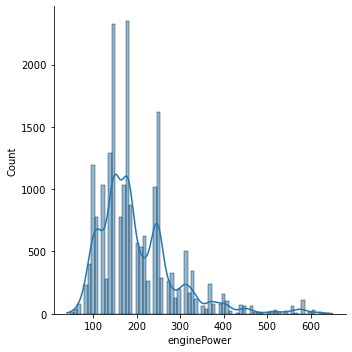

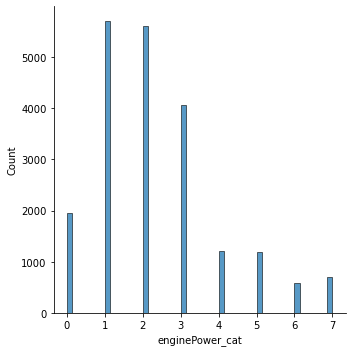

In [186]:
# Распределение изначальных данных
sns.displot(union[union.part==1].enginePower,kde=True)
# Распределение сгруппированных данных
sns.displot(union[union.part==1].enginePower_cat)

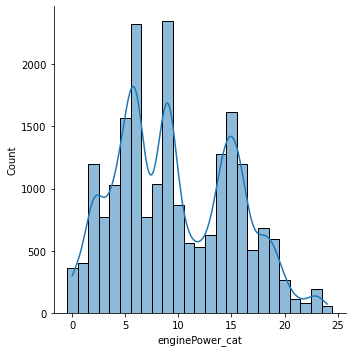

In [187]:
union['enginePower_cat'] = pd.cut(union.enginePower,bins=[-1,80,90,100,110,120,140,150,160,170,180,190,200,
                                                           210,220,240,250,300,310,350,400,450,500,550,600,700],
                                   labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

union['enginePower_cat'] = union['enginePower_cat'].astype('float64')
sns.displot(union[union.part==1].enginePower_cat,discrete=True,shrink=1,kde=True)

In [188]:
revision_check()

CBR MAPE: 19.81757194446171
GBR MAPE: 24.07277885539626


#### **engineDisplacement**

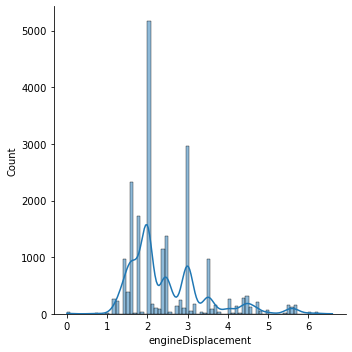

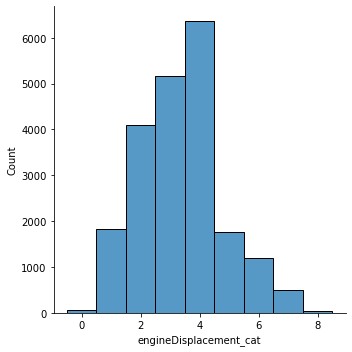

In [189]:
sns.displot(union[union.part==1].engineDisplacement,kde=True)
sns.displot(union[union.part==1].engineDisplacement_cat)

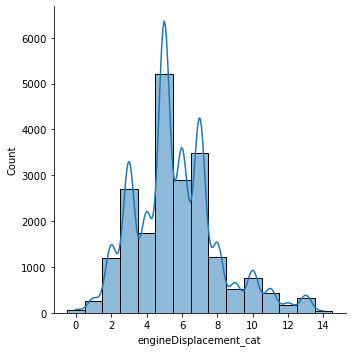

In [190]:
union['engineDisplacement_cat'] = pd.cut(union.engineDisplacement,
                                  bins=[-1, 1.1, 1.2, 1.4, 1.6, 1.8, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 10], 
                                  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14])
union.engineDisplacement_cat = union.engineDisplacement_cat.astype('float64')
sns.displot(union[union.part==1].engineDisplacement_cat,discrete=True,shrink=1,kde=True)

In [191]:
revision_check()

CBR MAPE: 19.938027882173614
GBR MAPE: 24.138418641760204


#### **productionDate**

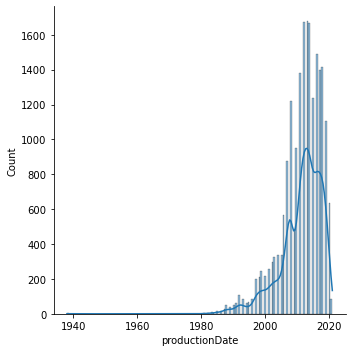

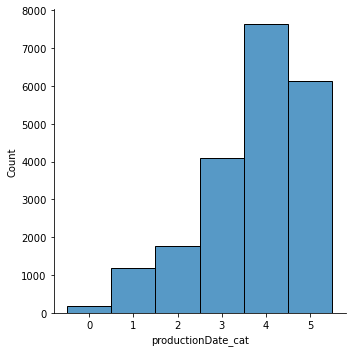

In [192]:
sns.displot(union[union.part==1].productionDate,kde=True)
sns.displot(union[union.part==1].productionDate_cat)

Поменям интервалы исходя из возраста автомобиля:
- до года
- от года до 3х лет
- от 3х до 5 лет
- от 5 до 7
- от 7 до 10
- от 10 до 15
- от 15 до 20
- от 20 до 25
- от 25 до 30
- старше 30

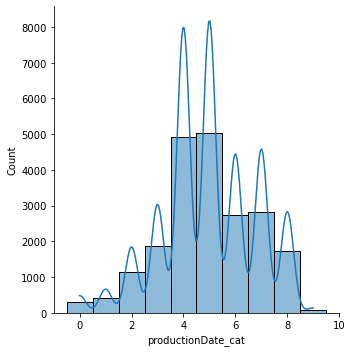

In [193]:
union['productionDate_cat'] = pd.cut(union.productionDate,
                              bins=[1900, 1991, 1996, 2001, 2006, 2011, 2014, 2016, 2018, 2020, 2021],
                              labels=[0, 1, 2, 3, 4, 5,6,7,8,9]) # чем новее ТС, тем выше значение
union.productionDate_cat = union.productionDate_cat.astype('float64')
sns.displot(union[union.part==1].productionDate_cat,discrete=True,shrink=1,kde=True)

In [194]:
revision_check()

CBR MAPE: 18.374191025346708
GBR MAPE: 22.971697380816337


#### **mileage**

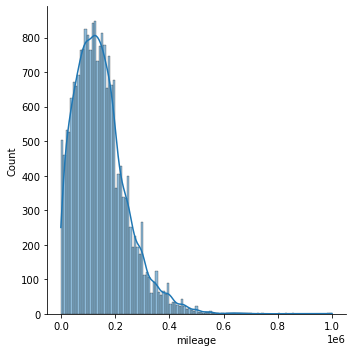

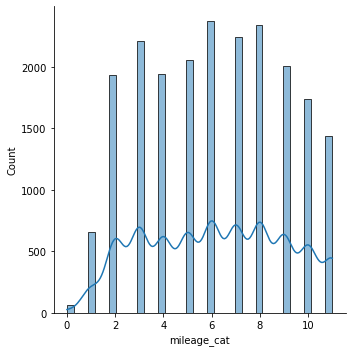

In [195]:
sns.displot(union[union.part==1].mileage,kde=True)
sns.displot(union[union.part==1].mileage_cat,kde=True)

In [196]:
union.mileage = union.mileage.apply(lambda x: 100 if x<100 else x)
union.mileage = union.mileage.apply(lambda x: round(x/100)*100 if x<1000 else x)
union.mileage = union.mileage.apply(lambda x: round(x/1000)*1000 if x>1000 and x<100000 else x)
union.mileage = union.mileage.apply(lambda x: round(x/10000)*10000 if x>100000 else x)

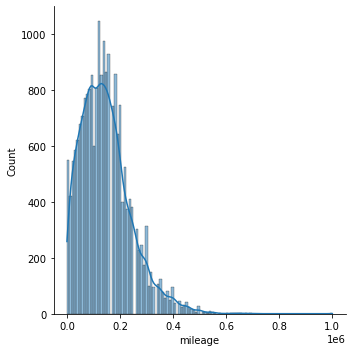

In [197]:
sns.displot(union[union.part==1].mileage,kde=True)

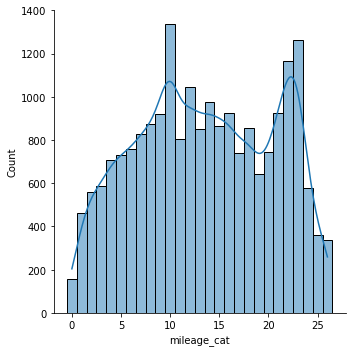

In [198]:
union.mileage_cat = pd.cut(union.mileage,
                       bins=[-1,1000,10000,20000,30000,40000,
                             50000,60000,70000,80000,90000,100000,
                             110000,120000,130000,140000,150000,
                             160000,170000,180000,190000,200000,
                             225000,250000,300000,350000,400000,10000000],
                       labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,
                               16,17,18,19,20,21,22,23,24,25,26])
union.mileage_cat = union.mileage_cat.astype('float64')
sns.displot(union[union.part==1].mileage_cat,discrete=True,shrink=1,kde=True)

In [199]:
revision_check()

CBR MAPE: 18.084510103604348
GBR MAPE: 23.13066577116145


#### **vehicleTransmission**

Ранее, мы воспользовались преобразованием признака во вспомогательные переменные. Попробуем теперь бинарное кодирование. Все, что не является механической коробкой передач, отнесем к автоматической

In [200]:
union['Transmission_cat'] = union.vehicleTransmission.apply(lambda x: 'auto' if x!='mech' else x)
union.Transmission_cat = union.Transmission_cat.map({'auto':1,'mech':0})
union.Transmission_cat = union.Transmission_cat.astype('float64')
union.Transmission_cat.value_counts()

1.0    45613
0.0    10077
Name: Transmission_cat, dtype: int64

Добавим получившийся признак Transmission_cat

In [201]:
model_columns = ['owners','vehicle_passport','steering',
                 'fuelType', 'numberOfDoors','tmission_auto','tmission_mech',
                 'tmission_rob','tmission_var', 'enginePower_cat','brand_AUDI',
                 'brand_BMW','brand_HONDA', 'brand_INFINITI','brand_LEXUS',
                 'brand_MERCEDES','brand_MITSUBISHI','brand_NISSAN',
                 'brand_SKODA', 'brand_TOYOTA','brand_VOLKSWAGEN',
                 'brand_VOLVO','body_coupe', 'body_hatchback','body_minivan',
                 'body_off_road','body_others', 'body_sedan','body_station_wagon',
                 'vehicle_drive_all','vehicle_drive_front','vehicle_drive_rear',
                 'productionDate_cat','engineDisplacement_cat', 'mileage_cat',
                 'color_code','Transmission_cat']

In [202]:
revision_check()

CBR MAPE: 18.271131682966114
GBR MAPE: 23.13066577116145


И попробуем убрать вспомогательные переменные 'tmission_auto','tmission_mech','tmission_rob','tmission_var'

In [203]:
model_columns = ['owners','vehicle_passport','steering',
                 'fuelType', 'numberOfDoors','enginePower_cat','brand_AUDI',
                 'brand_BMW','brand_HONDA', 'brand_INFINITI','brand_LEXUS',
                 'brand_MERCEDES','brand_MITSUBISHI','brand_NISSAN',
                 'brand_SKODA', 'brand_TOYOTA','brand_VOLKSWAGEN',
                 'brand_VOLVO','body_coupe', 'body_hatchback','body_minivan',
                 'body_off_road','body_others', 'body_sedan','body_station_wagon',
                 'vehicle_drive_all','vehicle_drive_front','vehicle_drive_rear',
                 'productionDate_cat','engineDisplacement_cat', 'mileage_cat',
                 'color_code','Transmission_cat']

In [204]:
revision_check()

CBR MAPE: 18.30072919328257
GBR MAPE: 22.82049813493724


#### **vehicle_passport и steering**

Признаки бинарные, посмотрим на распределение классов как в целом в union, так и в части, относящейся к df

In [205]:
union.vehicle_passport.value_counts(normalize=True)*100

1    86.895313
0    13.104687
Name: vehicle_passport, dtype: float64

In [206]:
union[union.part==1].vehicle_passport.value_counts(normalize=True)*100

1    87.092935
0    12.907065
Name: vehicle_passport, dtype: float64

In [207]:
union.steering.value_counts(normalize=True)*100

0    96.505656
1     3.494344
Name: steering, dtype: float64

In [208]:
union[union.part==1].steering.value_counts(normalize=True)*100

0    97.395734
1     2.604266
Name: steering, dtype: float64

In [209]:
union.Transmission_cat.value_counts()

1.0    45613
0.0    10077
Name: Transmission_cat, dtype: int64

Посмотрим на значимость признаков с помощью f_regression и mutual_info_regression

In [210]:
X = union[union.part==1][model_columns].values
Y = union[union.part==1].vehicle_price
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

from sklearn.feature_selection import f_regression, mutual_info_regression
f_test, _ = f_regression(X, Y)
f_test = pd.Series(f_test,index=union[model_columns].columns).sort_values(ascending=False)
f_test[:15]

productionDate_cat        10125.101982
mileage_cat                9388.743410
enginePower_cat            7861.851115
vehicle_drive_all          3683.160549
engineDisplacement_cat     3467.157977
vehicle_drive_front        3291.489104
brand_MERCEDES             2633.167781
owners                     2522.391324
Transmission_cat           1441.099191
fuelType                   1398.757536
body_off_road              1383.916114
vehicle_passport            604.691431
brand_SKODA                 569.762808
color_code                  528.322829
brand_MITSUBISHI            502.553960
dtype: float64

In [211]:
m_info = pd.Series(mutual_info_regression(X, Y),index=union[model_columns].columns).sort_values(ascending=False)
m_info[:15]

productionDate_cat        0.529637
enginePower_cat           0.431280
mileage_cat               0.340656
engineDisplacement_cat    0.242176
vehicle_drive_all         0.165985
vehicle_drive_front       0.159808
owners                    0.125345
Transmission_cat          0.110003
body_off_road             0.099328
fuelType                  0.084657
brand_MERCEDES            0.047968
vehicle_passport          0.045108
brand_SKODA               0.043963
numberOfDoors             0.033525
body_hatchback            0.031388
dtype: float64

In [212]:
f_test = set(f_test[:15].index)
m_info = set(m_info[:15].index)

In [213]:
# множество элементов, принадлежащих обоим множествам (пересечение)
f_test&m_info

{'Transmission_cat',
 'body_off_road',
 'brand_MERCEDES',
 'brand_SKODA',
 'engineDisplacement_cat',
 'enginePower_cat',
 'fuelType',
 'mileage_cat',
 'owners',
 'productionDate_cat',
 'vehicle_drive_all',
 'vehicle_drive_front',
 'vehicle_passport'}

In [214]:
# множество из элементов, встречающихся в одном множестве, но не встречающиеся в обоих
f_test^m_info

{'body_hatchback', 'brand_MITSUBISHI', 'color_code', 'numberOfDoors'}

Видим, что в топ-15 на последних позициях входит только vehicle_passport, а значимость steering еще меньше. Возможно потому, что признак фактически состоит из одного значения. Попробуем убрать оба признака.

In [215]:
# Убираем признак 'vehicle_passport','steering'
model_columns = ['owners',
                 'fuelType', 'numberOfDoors','enginePower_cat','brand_AUDI',
                 'brand_BMW','brand_HONDA', 'brand_INFINITI','brand_LEXUS',
                 'brand_MERCEDES','brand_MITSUBISHI','brand_NISSAN',
                 'brand_SKODA', 'brand_TOYOTA','brand_VOLKSWAGEN',
                 'brand_VOLVO','body_coupe', 'body_hatchback','body_minivan',
                 'body_off_road','body_others', 'body_sedan','body_station_wagon',
                 'vehicle_drive_all','vehicle_drive_front','vehicle_drive_rear',
                 'productionDate_cat','engineDisplacement_cat', 'mileage_cat',
                 'color_code','Transmission_cat']

In [216]:
revision_check()

CBR MAPE: 18.566415743821345
GBR MAPE: 22.84428344861903


Показатели ухудшились. Оставим признаки и попробуем закодировать их во вспомогательные переменные

In [217]:
union['vehicle_passport_temp'] = union.vehicle_passport.map({1:'original',0:'duplicate'})
union = pd.concat([union,pd.get_dummies(union.vehicle_passport_temp,
                                        prefix='passport')],axis=1)
union.drop(['vehicle_passport_temp'],axis=1,inplace=True)

In [218]:
union['steering_temp'] = union.steering.map({1:'left',0:'right'})
union = pd.concat([union,pd.get_dummies(union.steering_temp,
                                        prefix='steering')],axis=1)
union.drop(['steering_temp'],axis=1,inplace=True)

In [219]:
union.sample(3)

,owners,vehicleTransmission,bodyType,vehicle_passport,vehicle_drive,mileage,steering,color,brand,productionDate,model_name,vehicle_price,engineDisplacement,enginePower,fuelType,numberOfDoors,part,tmission_auto,tmission_mech,tmission_rob,tmission_var,enginePower_cat,brand_AUDI,brand_BMW,brand_HONDA,brand_INFINITI,brand_LEXUS,brand_MERCEDES,brand_MITSUBISHI,brand_NISSAN,brand_SKODA,brand_TOYOTA,brand_VOLKSWAGEN,brand_VOLVO,bodyType_enlargement,body_compactvan,body_coupe,body_hatchback,body_liftback,body_minivan,body_off_road,body_others,body_sedan,body_station_wagon,vehicle_drive_all,vehicle_drive_front,vehicle_drive_rear,productionDate_cat,engineDisplacement_cat,mileage_cat,color_code,Transmission_cat,passport_duplicate,passport_original,steering_left,steering_right
4320,0,rob,купе,1,rear,18000,0,белый,BMW,2016,M4,4.766031e+06,3.0,430.0,2,2.0,1,0,0,1,0,20.0,0,1,0,0,0,0,0,0,0,0,0,0,coupe,0,1,0,0,0,0,0,0,0,0,0,1,6.0,7.0,2.0,2,1.0,0,1,0,1
19865,2,auto,внедорожник,1,all,190000,0,чёрный,VOLKSWAGEN,2014,TOUAREG,1.672444e+06,3.0,240.0,1,5.0,1,1,0,0,0,14.0,0,0,0,0,0,0,0,0,0,0,1,0,off_road,0,0,0,0,0,1,0,0,0,1,0,0,5.0,7.0,19.0,3,1.0,0,1,0,1
38342,2,auto,седан,1,all,310000,0,коричневый,MERCEDES,2010,E-CLASS,NaN,3.5,270.0,2,4.0,0,1,0,0,0,16.0,0,0,0,0,0,1,0,0,0,0,0,0,sedan,0,0,0,0,0,0,0,1,0,1,0,0,4.0,8.0,24.0,1,1.0,0,1,0,1


Скорректируем список признаков

In [220]:
model_columns = ['owners',
                 'fuelType', 'numberOfDoors','enginePower_cat','brand_AUDI',
                 'brand_BMW','brand_HONDA', 'brand_INFINITI','brand_LEXUS',
                 'brand_MERCEDES','brand_MITSUBISHI','brand_NISSAN',
                 'brand_SKODA', 'brand_TOYOTA','brand_VOLKSWAGEN',
                 'brand_VOLVO','body_coupe', 'body_hatchback','body_minivan',
                 'body_off_road','body_others', 'body_sedan','body_station_wagon',
                 'vehicle_drive_all','vehicle_drive_front','vehicle_drive_rear',
                 'productionDate_cat','engineDisplacement_cat', 'mileage_cat',
                 'color_code','Transmission_cat',
                 'passport_duplicate','passport_original','steering_left','steering_right']

In [221]:
revision_check()

CBR MAPE: 18.185593750541116
GBR MAPE: 22.824313759347696


Результаты лучше, чем совсем без признаков, но хуже чем с ними в бинарном представлении. Таким образом вернемся к их первоначальной версии

In [222]:
union.drop(['passport_duplicate',
            'passport_original',
            'steering_left',
            'steering_right'],axis=1,inplace=True)

In [223]:
model_columns = ['owners','vehicle_passport','steering',
                 'fuelType', 'numberOfDoors','enginePower_cat','brand_AUDI',
                 'brand_BMW','brand_HONDA', 'brand_INFINITI','brand_LEXUS',
                 'brand_MERCEDES','brand_MITSUBISHI','brand_NISSAN',
                 'brand_SKODA', 'brand_TOYOTA','brand_VOLKSWAGEN',
                 'brand_VOLVO','body_coupe', 'body_hatchback','body_minivan',
                 'body_off_road','body_others', 'body_sedan','body_station_wagon',
                 'vehicle_drive_all','vehicle_drive_front','vehicle_drive_rear',
                 'productionDate_cat','engineDisplacement_cat', 'mileage_cat',
                 'color_code','Transmission_cat']
revision_check()

CBR MAPE: 18.30072919328257
GBR MAPE: 22.82049813493724


#### **vehicle_price**

Посмотрим на целевую переменную

In [224]:
union.vehicle_price.describe()

count    2.100400e+04
mean     1.459923e+06
std      1.548880e+06
min      1.733102e+04
25%      5.632582e+05
50%      1.039861e+06
75%      1.818891e+06
max      2.409012e+07
Name: vehicle_price, dtype: float64

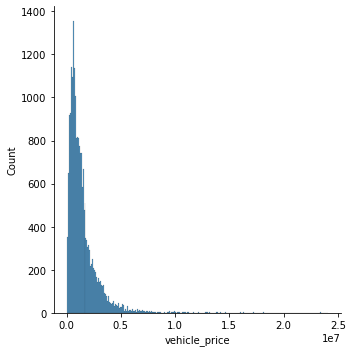

In [225]:
sns.displot(union.vehicle_price)

Попробуем привести распределение к нормальному виду.

In [226]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

VEHICLE_PRICE  distribution



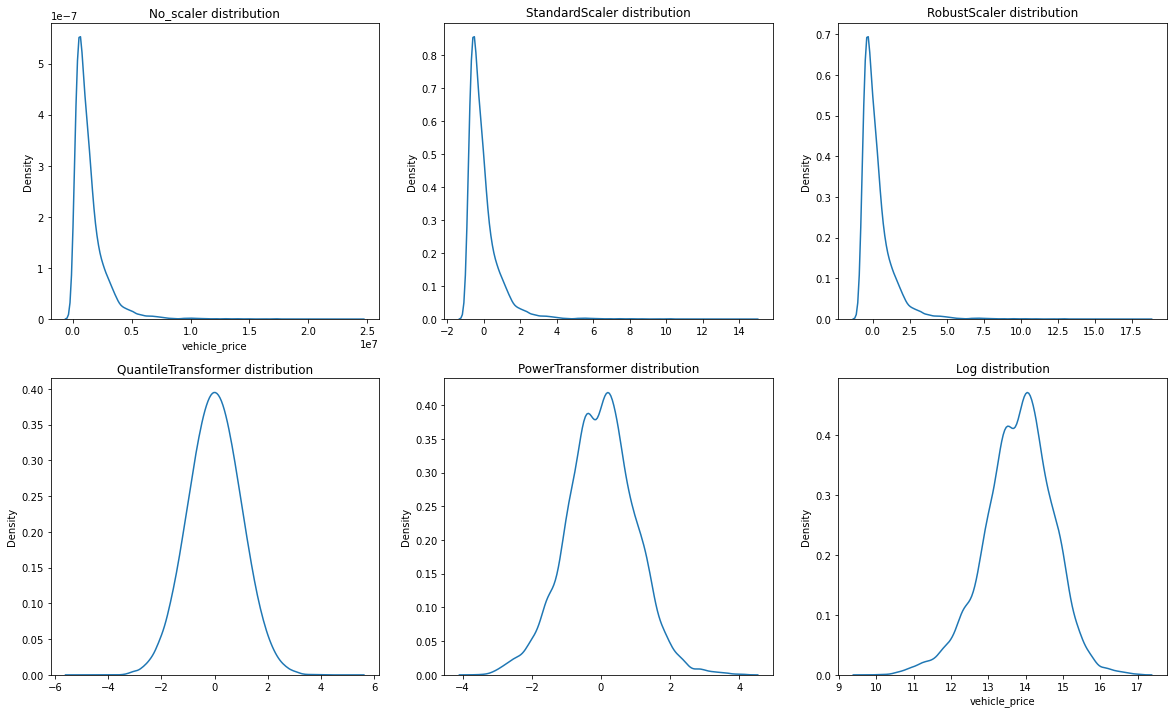

In [227]:
sc = StandardScaler()
rs = RobustScaler()
qt = QuantileTransformer(output_distribution='normal')
pt = PowerTransformer()

X = union[union.part==1][model_columns].values
Y = union[union.part==1].vehicle_price

_, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,12))
ax[0][0].set_title("No_scaler distribution")
ax[0][1].set_title("StandardScaler distribution")
ax[0][2].set_title("RobustScaler distribution")
ax[1][0].set_title("QuantileTransformer distribution")
ax[1][1].set_title("PowerTransformer distribution")
ax[1][2].set_title("Log distribution")
print('='*127)
print('VEHICLE_PRICE',' distribution')
print()
sns.kdeplot(Y, ax=ax[0][0])
sns.kdeplot(sc.fit_transform(Y.values.reshape(-1, 1)).flatten(), ax=ax[0][1])
sns.kdeplot(rs.fit_transform(Y.values.reshape(-1, 1)).flatten(), ax=ax[0][2])
sns.kdeplot(qt.fit_transform(Y.values.reshape(-1, 1)).flatten(), ax=ax[1][0])
sns.kdeplot(pt.fit_transform(Y.values.reshape(-1, 1)).flatten(), ax=ax[1][1])
sns.kdeplot(np.log(Y), ax=ax[1][2])
plt.show()

Хорошо справились 3 трансформера: QuantileTransformer, PowerTransformer и np.log. Учитывая, что у PowerTransformer и np.log примерно один и тот же результат, попробуем преобразование целевой переменной с помощью QuantileTransformer и np.log

In [228]:
from sklearn.preprocessing import PowerTransformer

X = union[union.part==1][model_columns].values
Y = union[union.part==1].vehicle_price
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

transformer = QuantileTransformer(output_distribution='normal')
y_train = transformer.fit_transform(y_train.values.reshape(-1,1))
y_test = transformer.transform(y_test.values.reshape(-1,1))

CBR = CatBoostRegressor(iterations=100,
                        random_state=42,
                        silent=True)
cbr_model = CBR.fit(X_train, y_train)
y_pred = cbr_model.predict(X_test)
print(mean_absolute_percentage_error(transformer.inverse_transform(y_test.reshape(-1,1)),
                                     transformer.inverse_transform(y_pred.reshape(-1,1)))*100)

16.036844382403704


In [229]:
X = union[union.part==1][model_columns].values
Y = np.log(union[union.part==1].vehicle_price)
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

CBR = CatBoostRegressor(iterations=100,
                        random_state=42,
                        silent=True)
cbr_model = CBR.fit(X_train, y_train)
y_pred = cbr_model.predict(X_test)
print(mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred))*100)

15.99264435366234


По результатам остановимся на np.log

In [230]:
revision_check('T')

CBR MAPE: 15.99264435366234
GBR MAPE: 18.33869931233157


In [231]:
union['vehicle_price_log'] = np.log(union.vehicle_price)

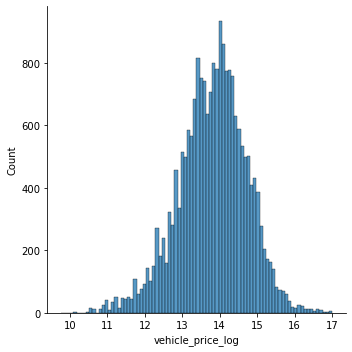

In [232]:
sns.displot(union.vehicle_price_log)

In [233]:
union.head()

,owners,vehicleTransmission,bodyType,vehicle_passport,vehicle_drive,mileage,steering,color,brand,productionDate,model_name,vehicle_price,engineDisplacement,enginePower,fuelType,numberOfDoors,part,tmission_auto,tmission_mech,tmission_rob,tmission_var,enginePower_cat,brand_AUDI,brand_BMW,brand_HONDA,brand_INFINITI,brand_LEXUS,brand_MERCEDES,brand_MITSUBISHI,brand_NISSAN,brand_SKODA,brand_TOYOTA,brand_VOLKSWAGEN,brand_VOLVO,bodyType_enlargement,body_compactvan,body_coupe,body_hatchback,body_liftback,body_minivan,body_off_road,body_others,body_sedan,body_station_wagon,vehicle_drive_all,vehicle_drive_front,vehicle_drive_rear,productionDate_cat,engineDisplacement_cat,mileage_cat,color_code,Transmission_cat,vehicle_price_log
0,0,rob,седан,1,front,13000,0,белый,AUDI,2019,A3,1.343154e+06,1.4,150.0,2,4.0,1,0,0,1,0,6.0,1,0,0,0,0,0,0,0,0,0,0,0,sedan,0,0,0,0,0,0,0,1,0,0,1,0,8.0,2.0,2.0,2,1.0,14.110531
1,2,rob,универсал,1,all,120000,0,синий,AUDI,2013,RS4,1.819757e+06,4.2,450.0,2,5.0,1,0,0,1,0,20.0,1,0,0,0,0,0,0,0,0,0,0,0,station_wagon,0,0,0,0,0,0,0,0,1,1,0,0,5.0,10.0,12.0,2,1.0,14.414214
2,2,rob,лифтбек,1,all,95000,0,коричневый,AUDI,2014,A5 SPORTBACK,1.386482e+06,2.0,220.0,2,5.0,1,0,0,1,0,13.0,1,0,0,0,0,0,0,0,0,0,0,0,liftback,0,0,0,1,0,0,0,0,0,1,0,0,5.0,5.0,10.0,1,1.0,14.142280
3,1,auto,лифтбек,1,all,31000,0,чёрный,AUDI,2014,RS7,3.665511e+06,4.0,560.0,2,5.0,1,1,0,0,0,23.0,1,0,0,0,0,0,0,0,0,0,0,0,liftback,0,0,0,1,0,0,0,0,0,1,0,0,5.0,9.0,4.0,3,1.0,15.114478
4,2,rob,седан,1,all,72000,0,белый,AUDI,2016,S6,2.642114e+06,4.0,450.0,2,4.0,1,0,0,1,0,20.0,1,0,0,0,0,0,0,0,0,0,0,0,sedan,0,0,0,0,0,0,0,1,0,1,0,0,6.0,9.0,8.0,2,1.0,14.787090


# **Обучение финальной модели**

## Тестирование и сравнение моделей

Теперь обучим остальные модели.

Первоначальные показатели:

|Модель|MAPE|
|:-|:-
|RandomForest       |19.5107
|DecisionTree_bag   |19.5398
|CatBoost           |20.3489
|ExtraTrees         |20.7001
|LGBM               |21.0173
|KNeighbors_bag     |22.2228
|KNeighbors         |22.4887
|DecisionTree       |23.4363
|GradientBoosting   |25.2751
|LinearRegression   |80.5775

Учитывая, что единичное дерево решений хуже, чем оно в бэггинге, а разница между KNeighbors и KNeighbors_bag не существенная, уберем из списка моделей DecisionTree и KNeighbors_bag. Также уберем и DecisionTree_bag, т.к. разницы с RandomForest практически нет.

In [234]:
estimators = {'LinearRegression':LinearRegression(),
              'RandomForest': RandomForestRegressor(random_state=42,criterion='mae'),
              'ExtraTrees': ExtraTreesRegressor(random_state=42,criterion='mae'),
              'KNeighbors': KNeighborsRegressor(n_neighbors=10),
              'GradientBoosting': GradientBoostingRegressor(random_state=42),
              'CatBoost': CatBoostRegressor(iterations=100,random_state=42,silent=True),
              'LGBM': lgb.LGBMRegressor(random_state=42)
             }

In [235]:
def training_models_with_log(estimators_dict):
    import time
    t_begin = time.time()
    all_mape = pd.DataFrame(columns=['mape'])
    for key in estimators_dict.keys():
        mape = models_mape_with_log(key)
        all_mape = pd.concat([all_mape,
                              pd.DataFrame([mape],index=[key],columns=['mape'])])
    print('Время поиска: ',int((time.time()-t_begin)/60),'мин')
    return all_mape

def models_mape_with_log (est_key):
    estimator = estimators[est_key]
    model = estimator.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred))*100

In [236]:
X = union[union.part==1][model_columns].values
Y = union[union.part==1].vehicle_price_log
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

all_mape_2 = training_models_with_log(estimators)
all_mape_2.sort_values('mape')

Время поиска:  53 мин


,mape
CatBoost,15.992644
RandomForest,16.353554
LGBM,16.472720
ExtraTrees,16.892321
GradientBoosting,18.338699
KNeighbors,20.513172
LinearRegression,22.535078


## Настройка гиперпараметров. Стекинг

Видно, что после работы с признаками, результаты моделей существенной улучшились, особенно на линейной регрессии. 
Теперь, для обучения попробуем **стэкинг**.

По результатам настройки гиперпараметров моделей и подбора комбинаций базовых и мета моделей, получилось следующее:

In [237]:
t_begin = time.time()
X = union[union.part==1][model_columns].values
Y = union[union.part==1].vehicle_price_log
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

cv = KFold(n_splits=5, shuffle=True,random_state=42)
estimators = [('LR', LinearRegression()),
              ('KNR', KNeighborsRegressor(n_neighbors=10,
                                          weights='distance',
                                          algorithm='ball_tree',
                                          p=1)),
              ('GBR', GradientBoostingRegressor(n_estimators=600,
                                                loss='huber',
                                                random_state=42,
                                                learning_rate=0.4)),
              ('LGBM', lgb.LGBMRegressor(n_estimators=2000,
                                         learning_rate=0.04,
                                         reg_alpha = 0.03,
                                         reg_lambda = 1,
                                         random_state=42)),
              ('CBR', CatBoostRegressor(loss_function='RMSE',
                                        learning_rate=0.1,
                                        random_state=42,
                                        silent=True))
             ]
final_estimator = RandomForestRegressor(n_estimators=200,
                                        criterion='mae',
                                        max_features='sqrt',
                                        random_state=42,
                                        n_jobs=-1)

StR = StackingRegressor(estimators=estimators,
                        final_estimator=final_estimator,
                        cv=cv,
                        n_jobs=-1,
                        passthrough=True)
StR.fit(X_train, y_train)
y_pred = StR.predict(X_test)
print('MAPE:',mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred))*100)
print('Время поиска: ',int((time.time()-t_begin)/60),'мин')

MAPE: 14.975520618671506
Время поиска:  6 мин


И, напоследок, учитывая способность catboost работать с категориальными (текстовыми) данными, добавим в список признаков для обучения **model_name**

In [250]:
model_columns_cat = ['owners','vehicle_passport','steering','model_name',
                 'fuelType', 'numberOfDoors','enginePower_cat','brand_AUDI',
                 'brand_BMW','brand_HONDA', 'brand_INFINITI','brand_LEXUS',
                 'brand_MERCEDES','brand_MITSUBISHI','brand_NISSAN',
                 'brand_SKODA', 'brand_TOYOTA','brand_VOLKSWAGEN',
                 'brand_VOLVO','body_coupe', 'body_hatchback','body_minivan',
                 'body_off_road','body_others', 'body_sedan','body_station_wagon',
                 'vehicle_drive_all','vehicle_drive_front','vehicle_drive_rear',
                 'productionDate_cat','engineDisplacement_cat', 'mileage_cat',
                 'color_code','Transmission_cat']

In [251]:
X = union[union.part==1][model_columns_cat].values
Y = union[union.part==1].vehicle_price_log
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

CBR = CatBoostRegressor(loss_function='MAPE',
                        cat_features = [3],
                        learning_rate=0.1,
                        random_state=42,
                        silent=True)
cbr_model = CBR.fit(X_train, y_train)
y_pred = cbr_model.predict(X_test)
print('MAPE:',mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred))*100)

MAPE: 14.128771257359695


Единичная модель оказалась сильнеей стэкинга, оставим её для предсказания стоимости ТС

# Итоговое предсказание

Сформируем файл для kaggle

In [254]:
submission = pd.read_csv('sample_submission.csv')

In [255]:
final_prediction = cbr_model.predict(union[union.part==0][model_columns_cat].values)
final_prediction = pd.Series(np.exp(final_prediction))
submission.price = final_prediction
submission.to_csv('submission.csv',index=False)

# Заключение

Значение метрики на неразмеченных данных составило **16.88193**. 
При прогнозирование стоимости автомобилей в низком ценовом диапазоне такая погрешность могла быть приемлемой, но в случаях с дорогими автомобилями, например, более 10 млн. рублей, такое отклоненение может препятствовать достижению поставленной цели.

Предположительно, уменьшение значения MAPE можно было бы достичь следующими способами:
- более глубокое изучение имеющихся признаков,
- более точная работа по настройке гиперпараметров моделей (параметры были настроены индивидуально для каждой модели, но в стекинге такая настройка не осуществлялась в связи с большими требованиями к вычислительным ресурсам),
- обучение моделей на большем количестве размеченных экземпляров.